# Installations & Imports

In [ ]:
!pip install -qq opentelemetry-api opentelemetry-sdk openinference-semantic-conventions openinference-instrumentation-openai opentelemetry-exporter-otlp arize-otel openai

In [ ]:
import os
import pandas as pd
from getpass import getpass
import json
from opentelemetry import trace
import random

import openai
import opentelemetry
from openai import OpenAI
from openinference.instrumentation.openai import OpenAIInstrumentor
from openinference.instrumentation import using_prompt_template
from arize_otel import register_otel, Endpoints
from openinference.semconv.trace import SpanAttributes, MessageAttributes, ToolAttributes, ToolCallAttributes

# Set Up API Keys and Register OTEL

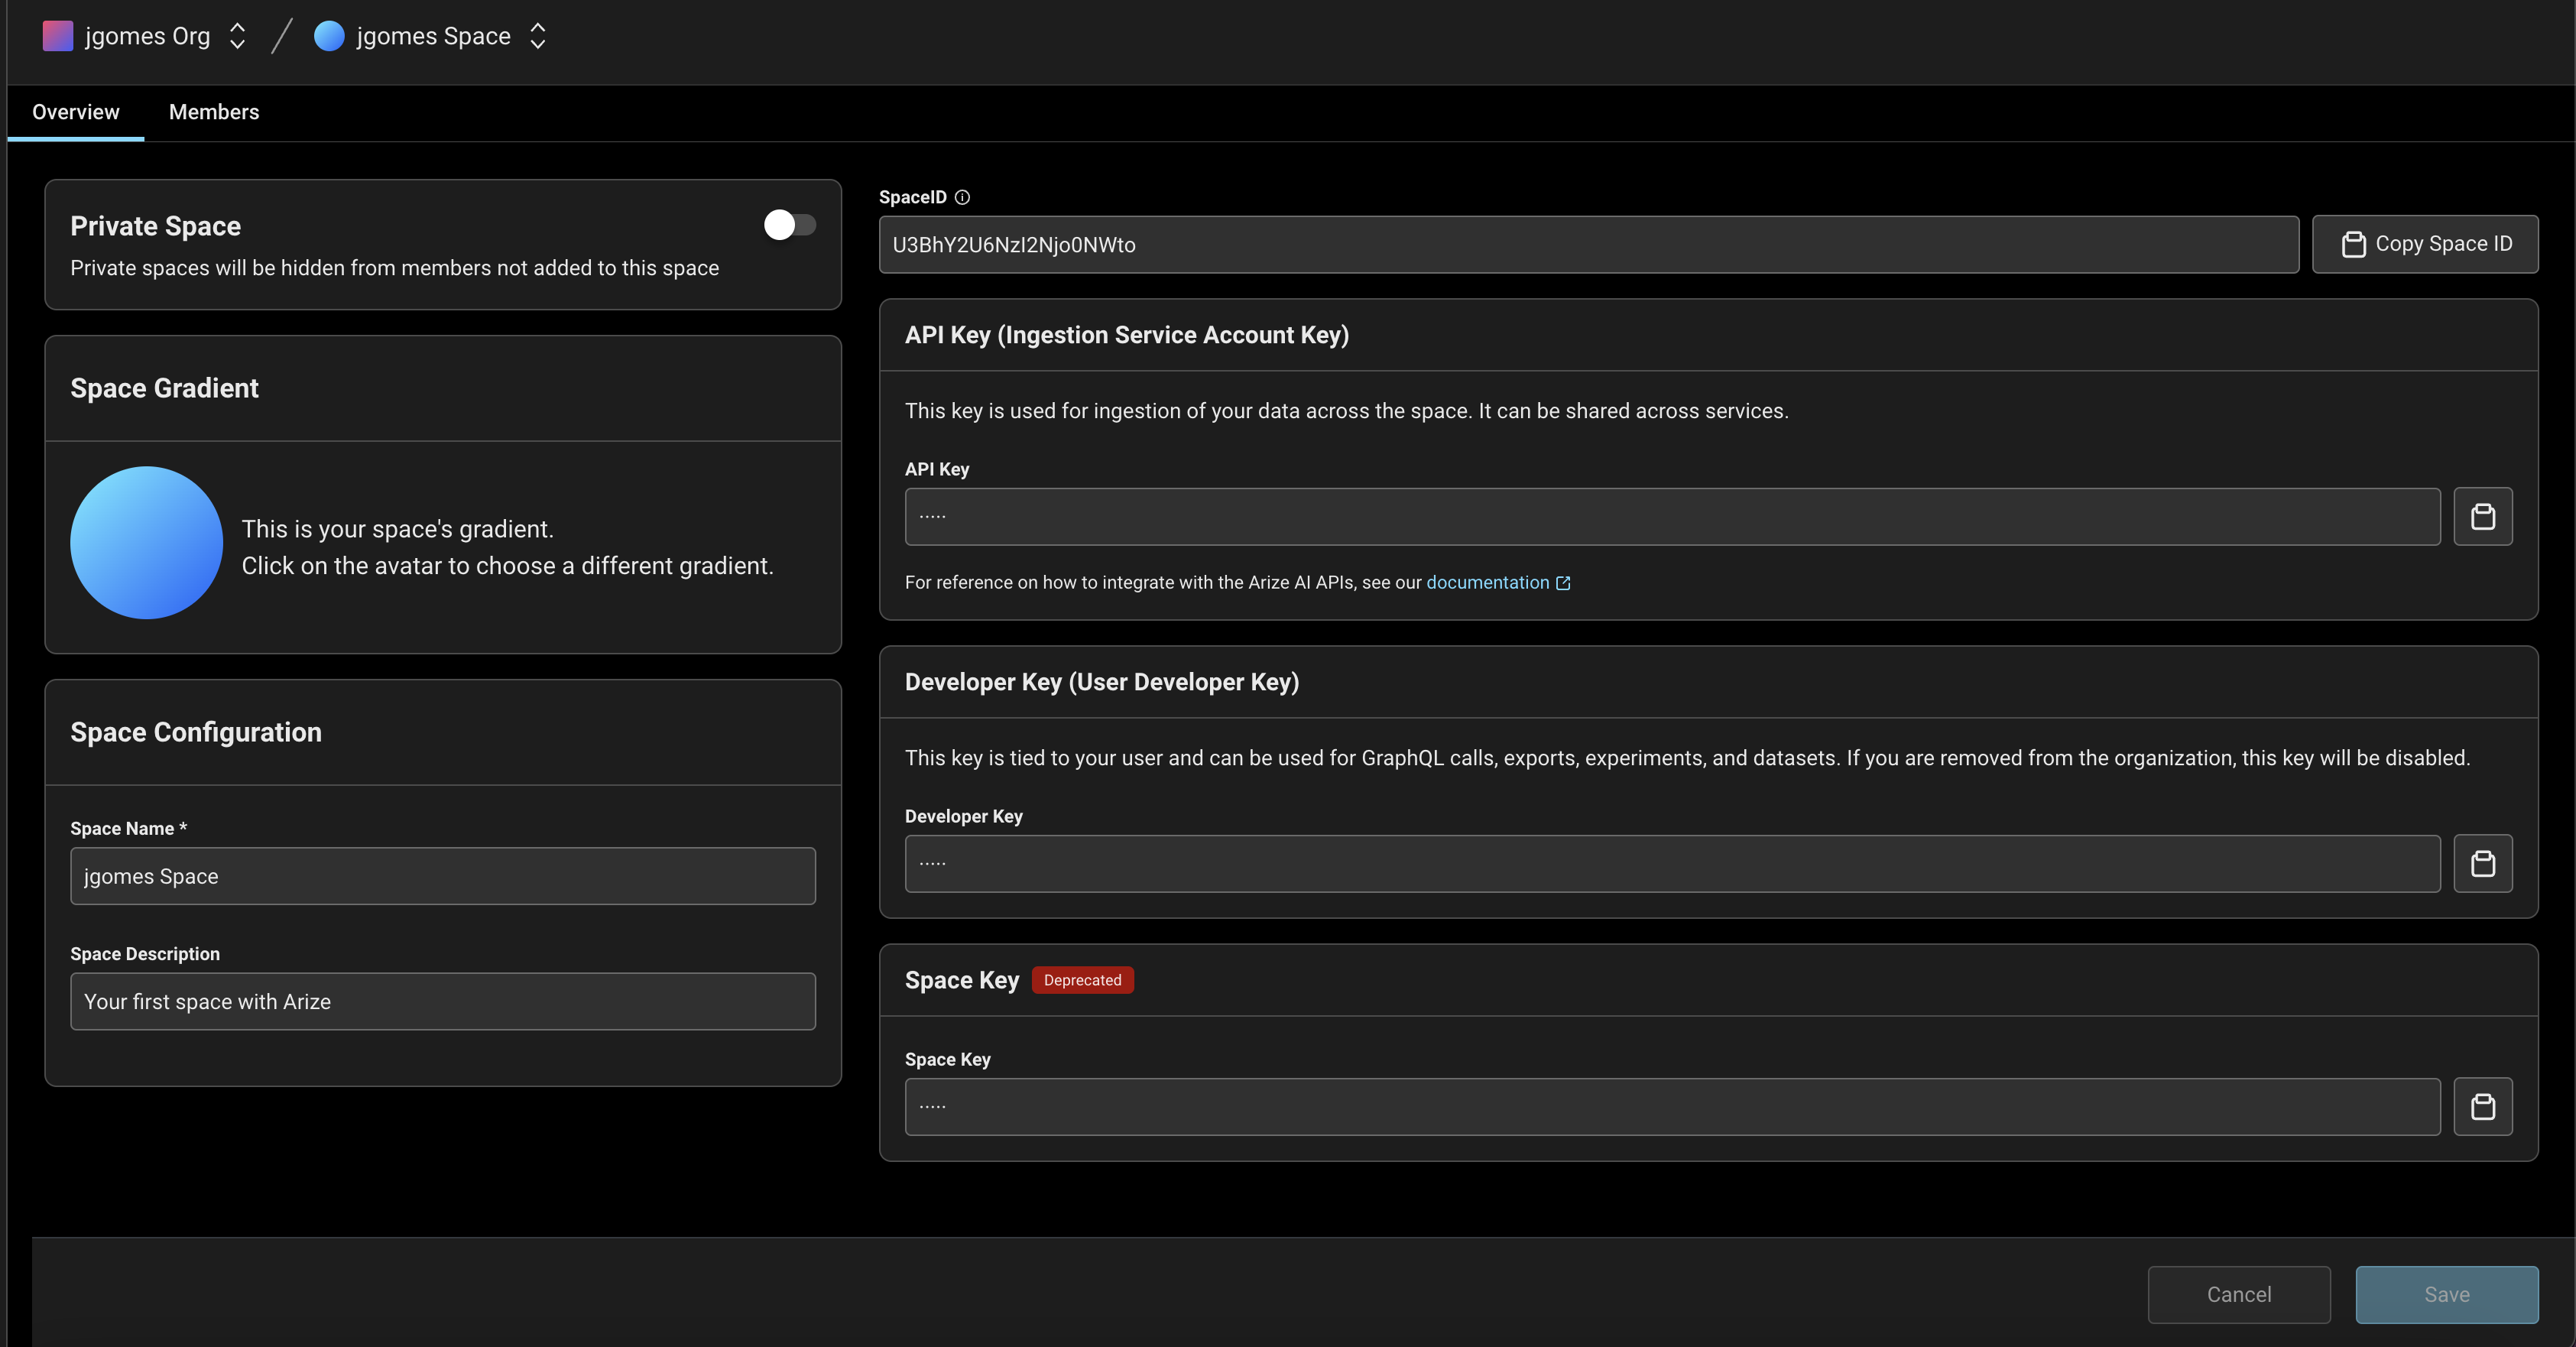

In [ ]:
model_name = "tutorial-manually-trace-openai-with-function-calls-v4"
model = "gpt-4o"

# Setup OTEL via our convenience function.
register_otel(
    endpoints=Endpoints.ARIZE,
    space_id=getpass("Enter your Arize Space ID: "),
    api_key=getpass("Enter your Arize API Key: "),
    model_id=model_name,
)

# Define Helper Functions for Instrumentation

The input and messages will be visible in the platform when we apply the following function:

In [ ]:
def trace_input_and_messages(span, messages):
    span.set_attribute(SpanAttributes.INPUT_VALUE, json.dumps({"messages": messages}))
    span.set_attribute(SpanAttributes.INPUT_MIME_TYPE, "application/json")
    for i, msge in enumerate(messages):
        span.set_attribute(f"{SpanAttributes.LLM_INPUT_MESSAGES}.{i}.{MessageAttributes.MESSAGE_ROLE}", msge["role"])
        if "content" in msge and msge["content"] is not None:
            span.set_attribute(f"{SpanAttributes.LLM_INPUT_MESSAGES}.{i}.{MessageAttributes.MESSAGE_CONTENT}", msge["content"])
        if "tool_calls" in msge and msge["tool_calls"] is not None:
            for j in range(len(msge["tool_calls"])):
                span.set_attribute(
                    f"{SpanAttributes.LLM_INPUT_MESSAGES}.{i}.{MessageAttributes.MESSAGE_TOOL_CALLS}.{j}.{ToolCallAttributes.TOOL_CALL_FUNCTION_ARGUMENTS_JSON}",
                    json.dumps(msge["tool_calls"][j]["function"]["arguments"]))
                span.set_attribute(
                    f"{SpanAttributes.LLM_INPUT_MESSAGES}.{i}.{MessageAttributes.MESSAGE_TOOL_CALLS}.{j}.{ToolCallAttributes.TOOL_CALL_FUNCTION_NAME}",
                    json.dumps(msge["tool_calls"][j]["function"]["name"]))

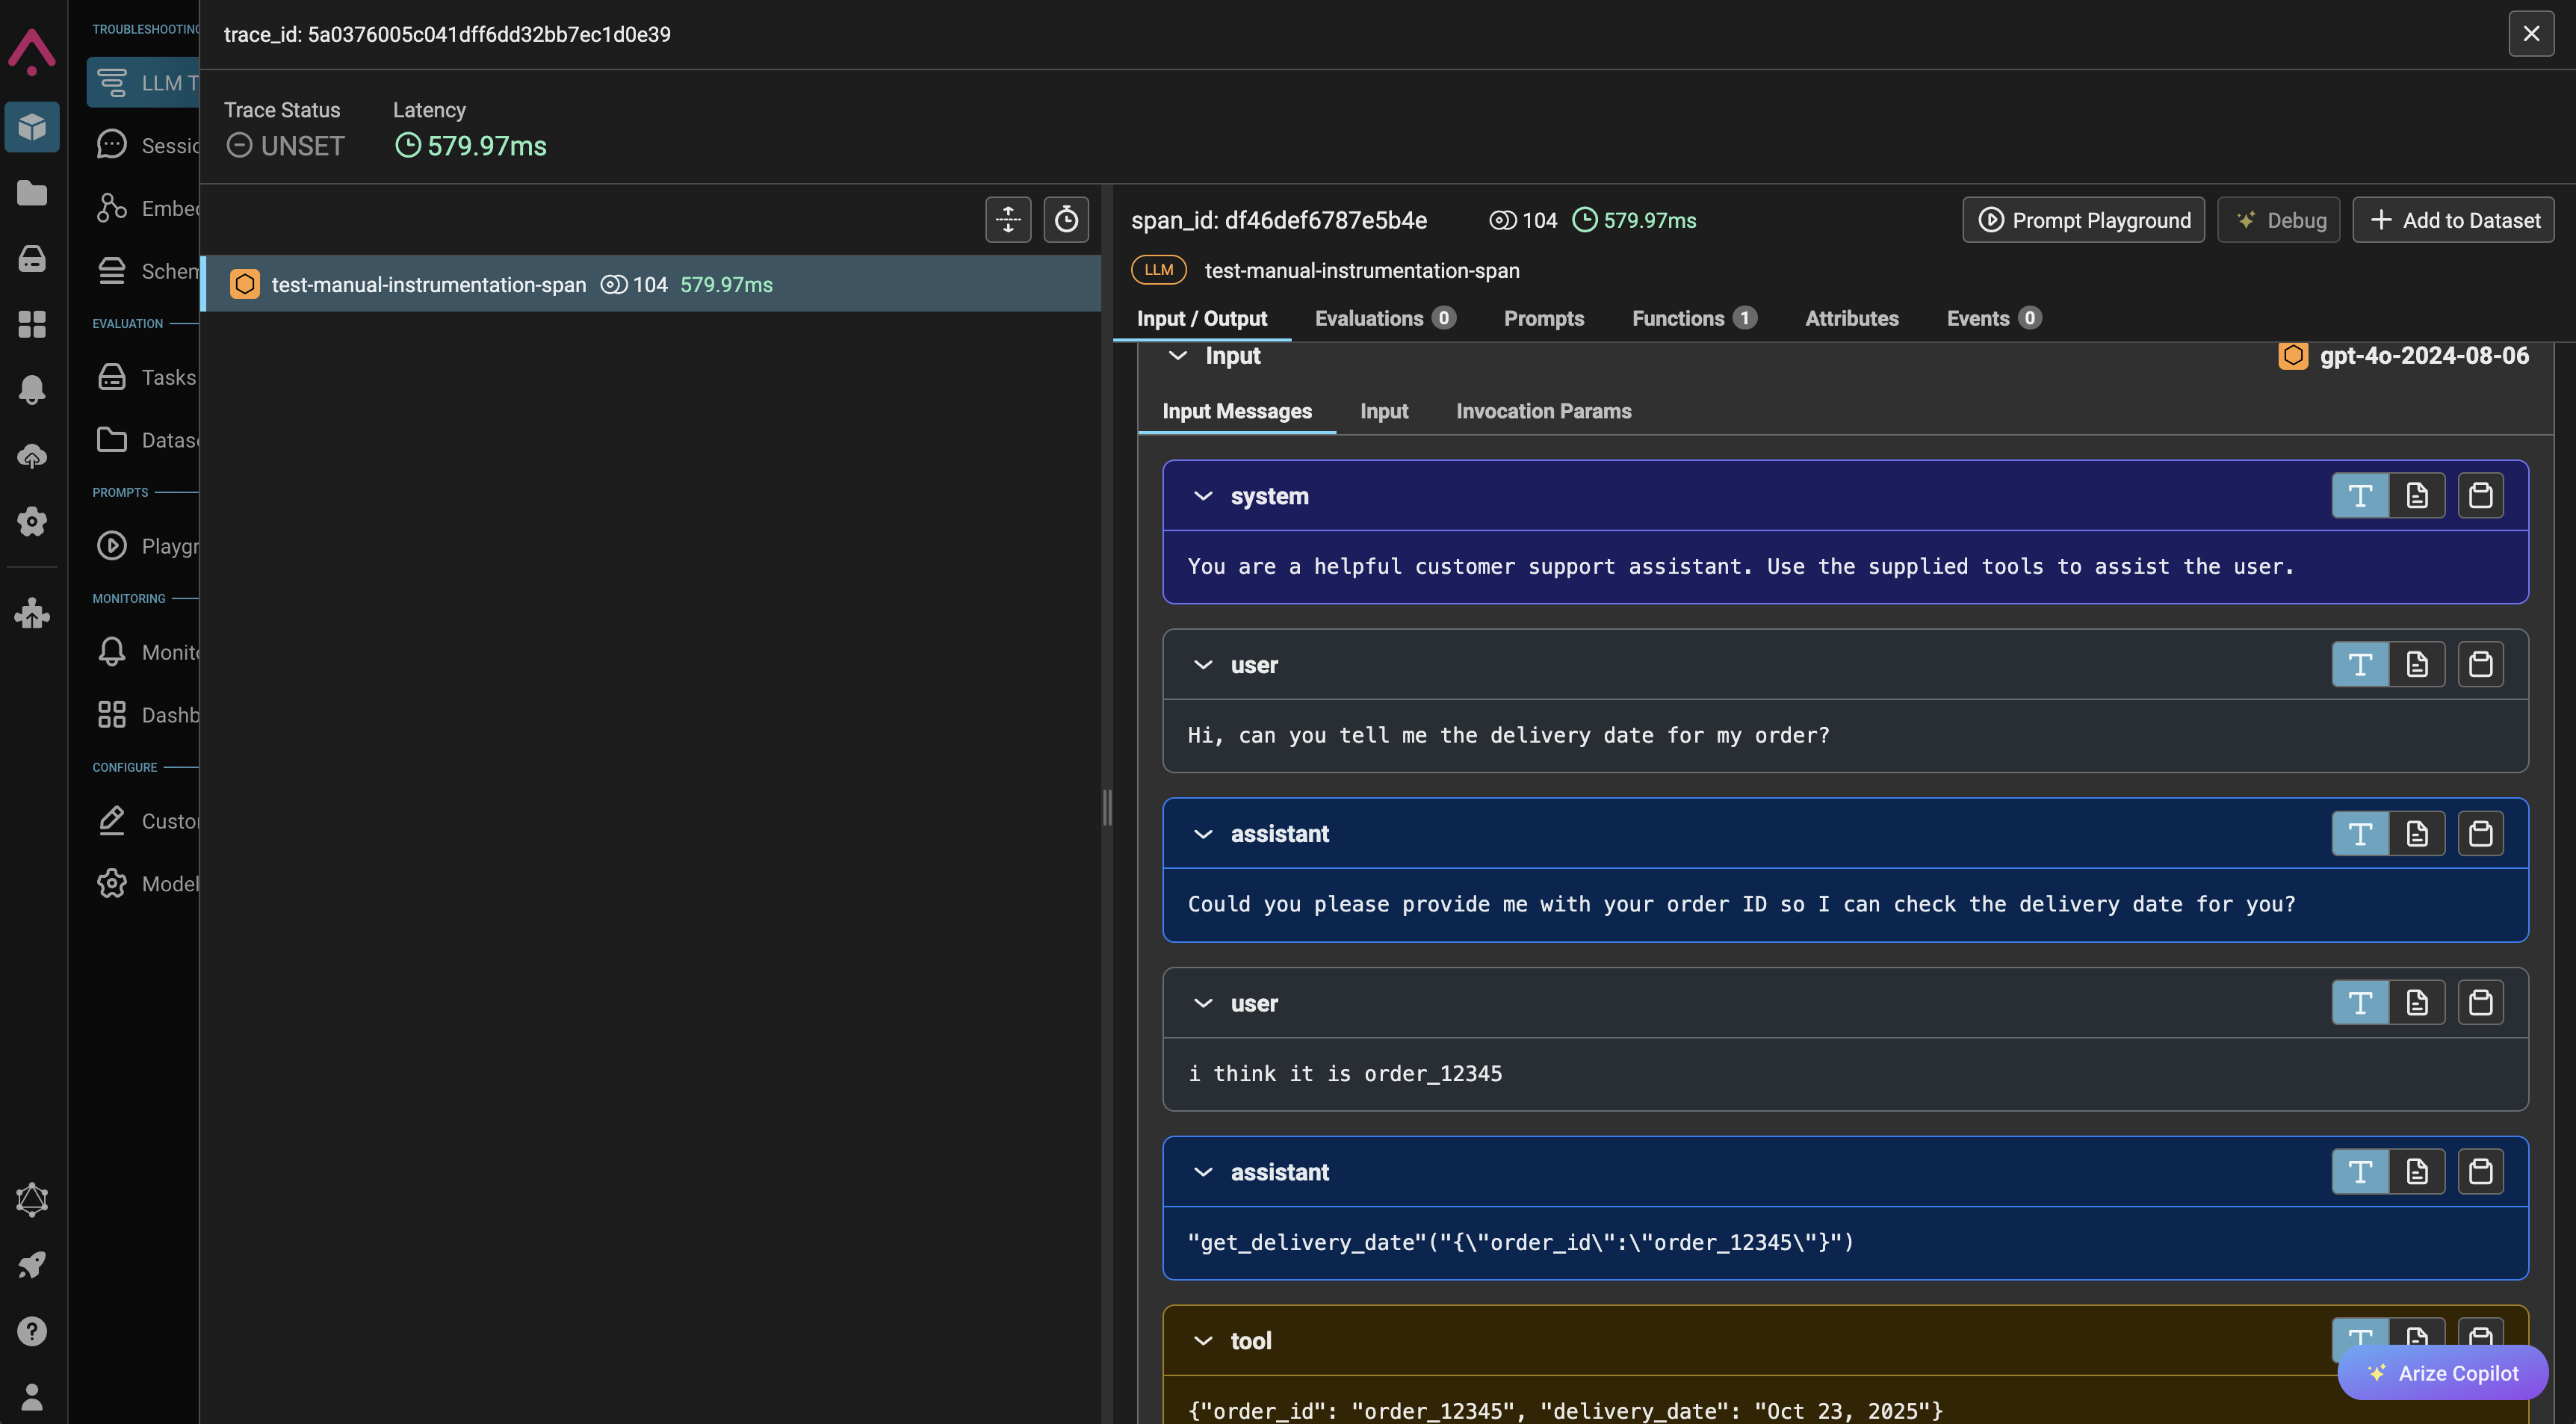

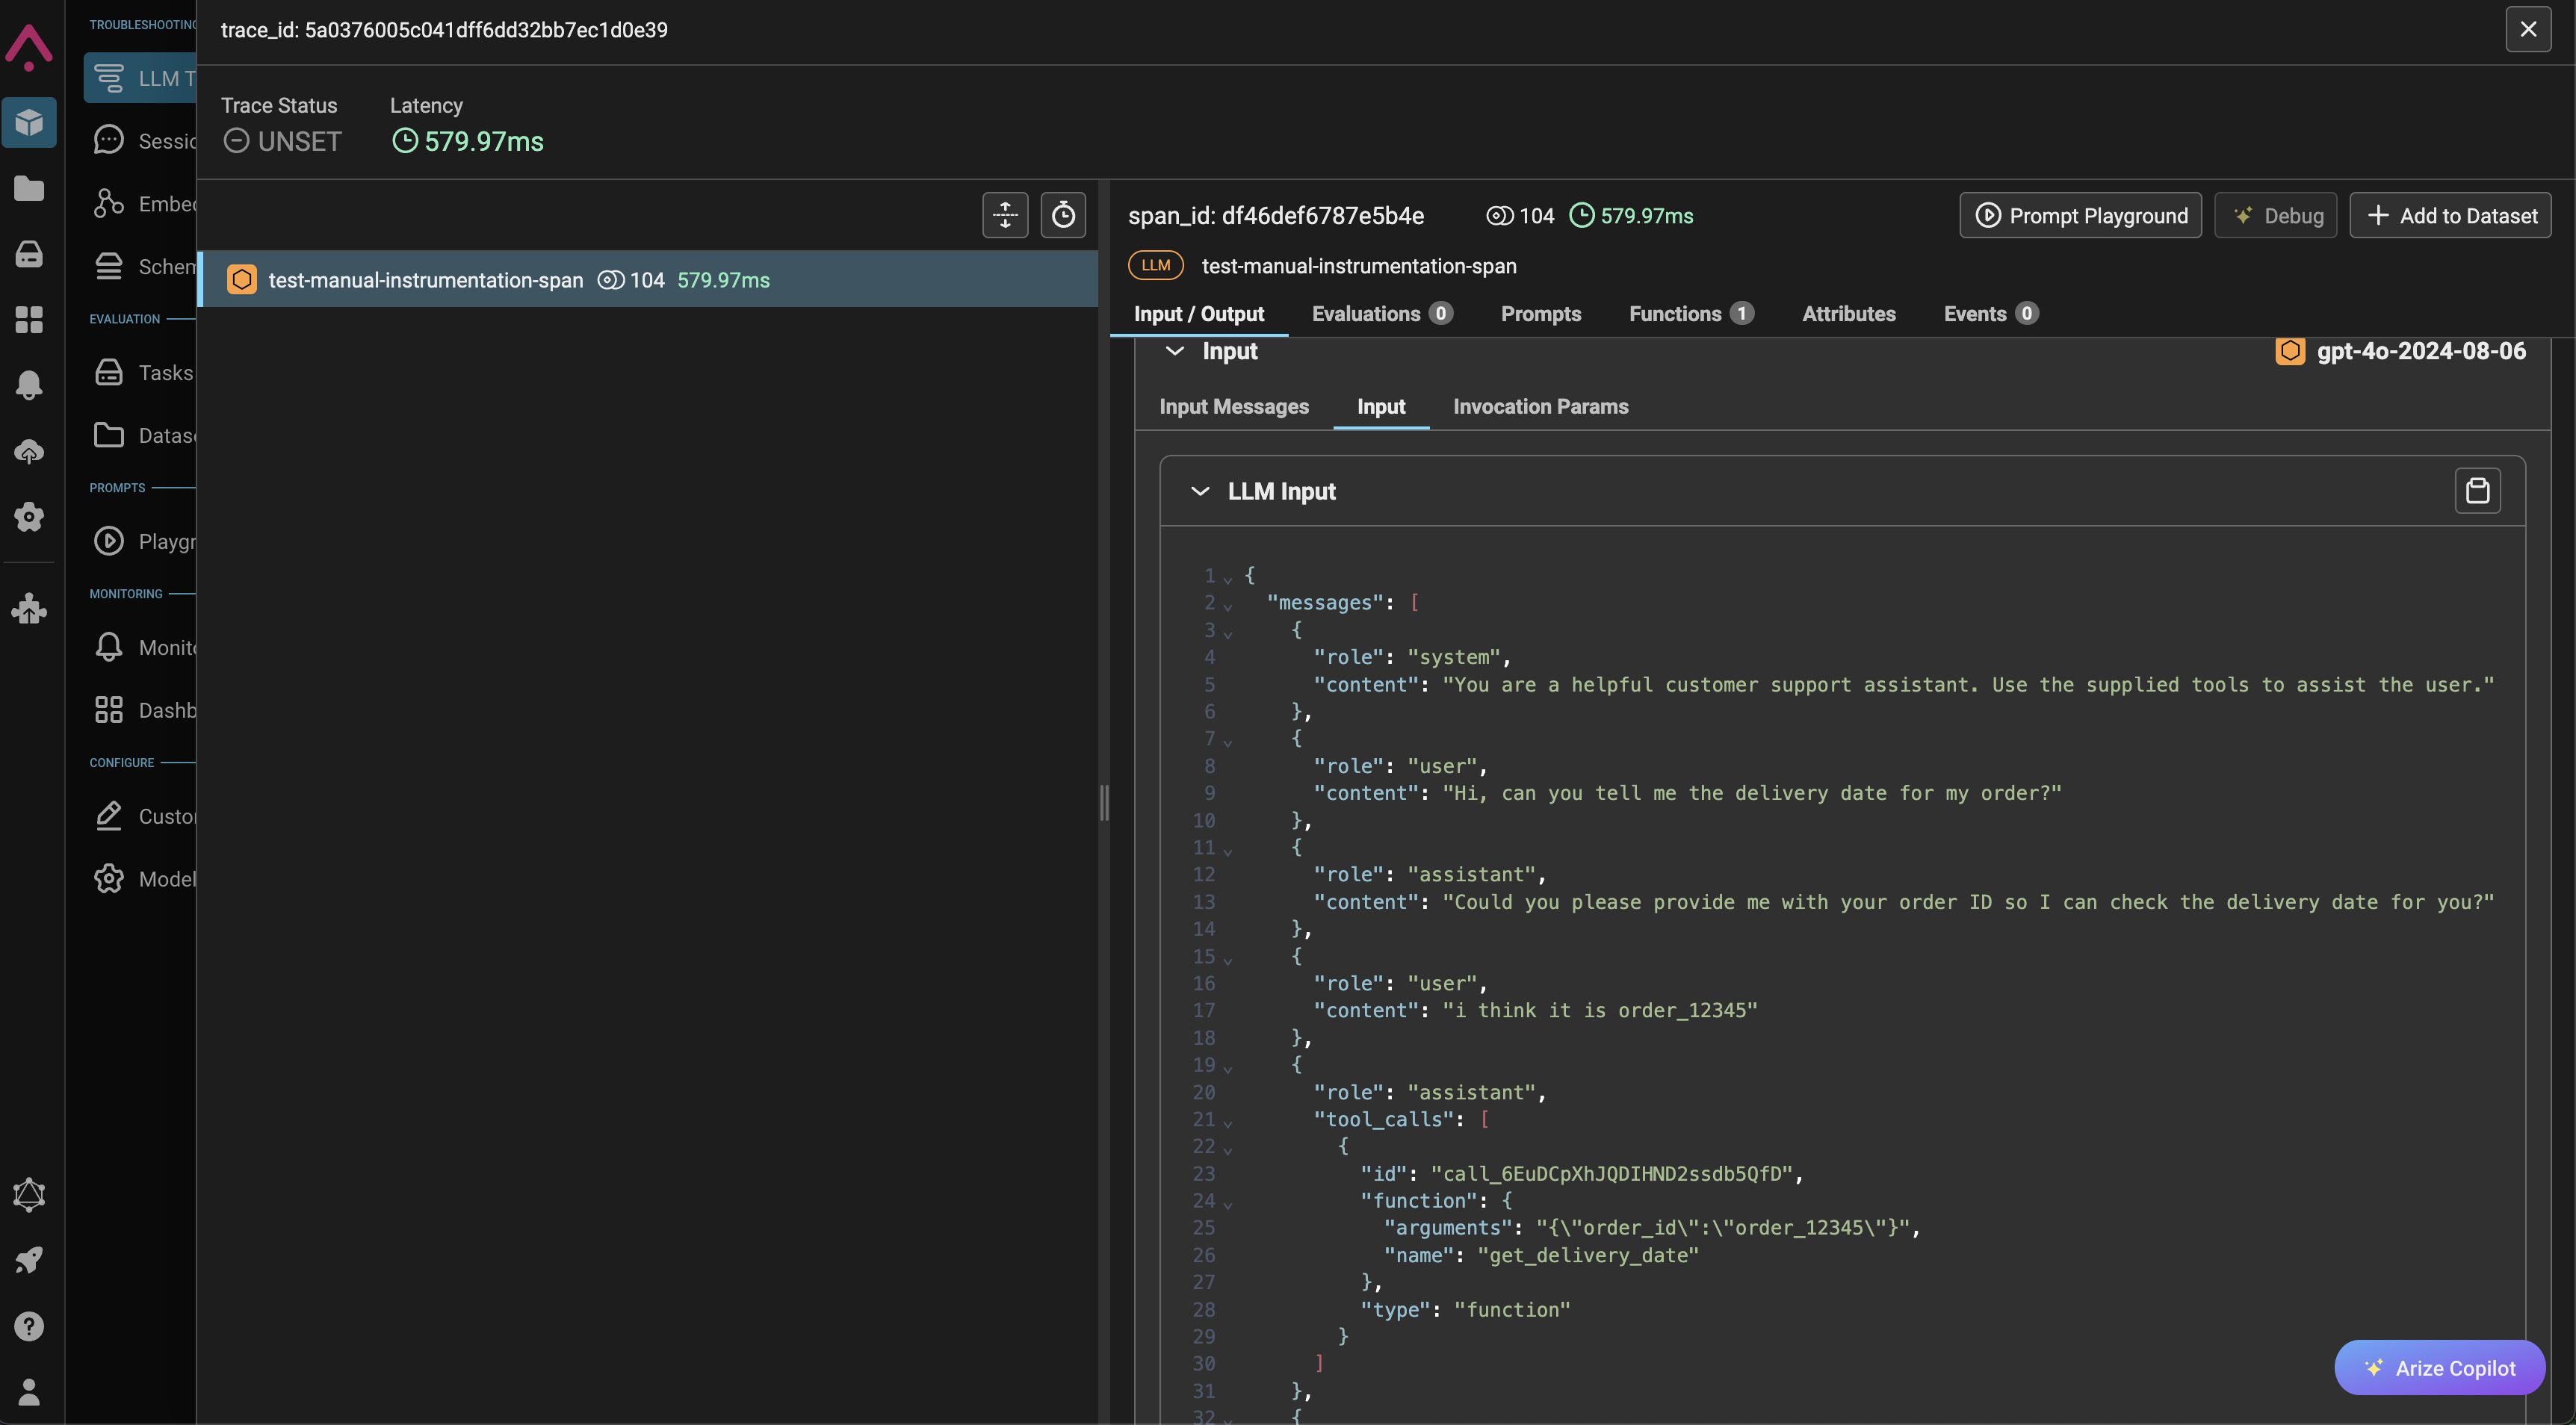

The next function will instrument the functions definition:

In [ ]:
def trace_function_definition(span, tools):
    span.set_attribute(f"{SpanAttributes.LLM_TOOLS}.0.{ToolAttributes.TOOL_JSON_SCHEMA}", json.dumps(tools[0]))

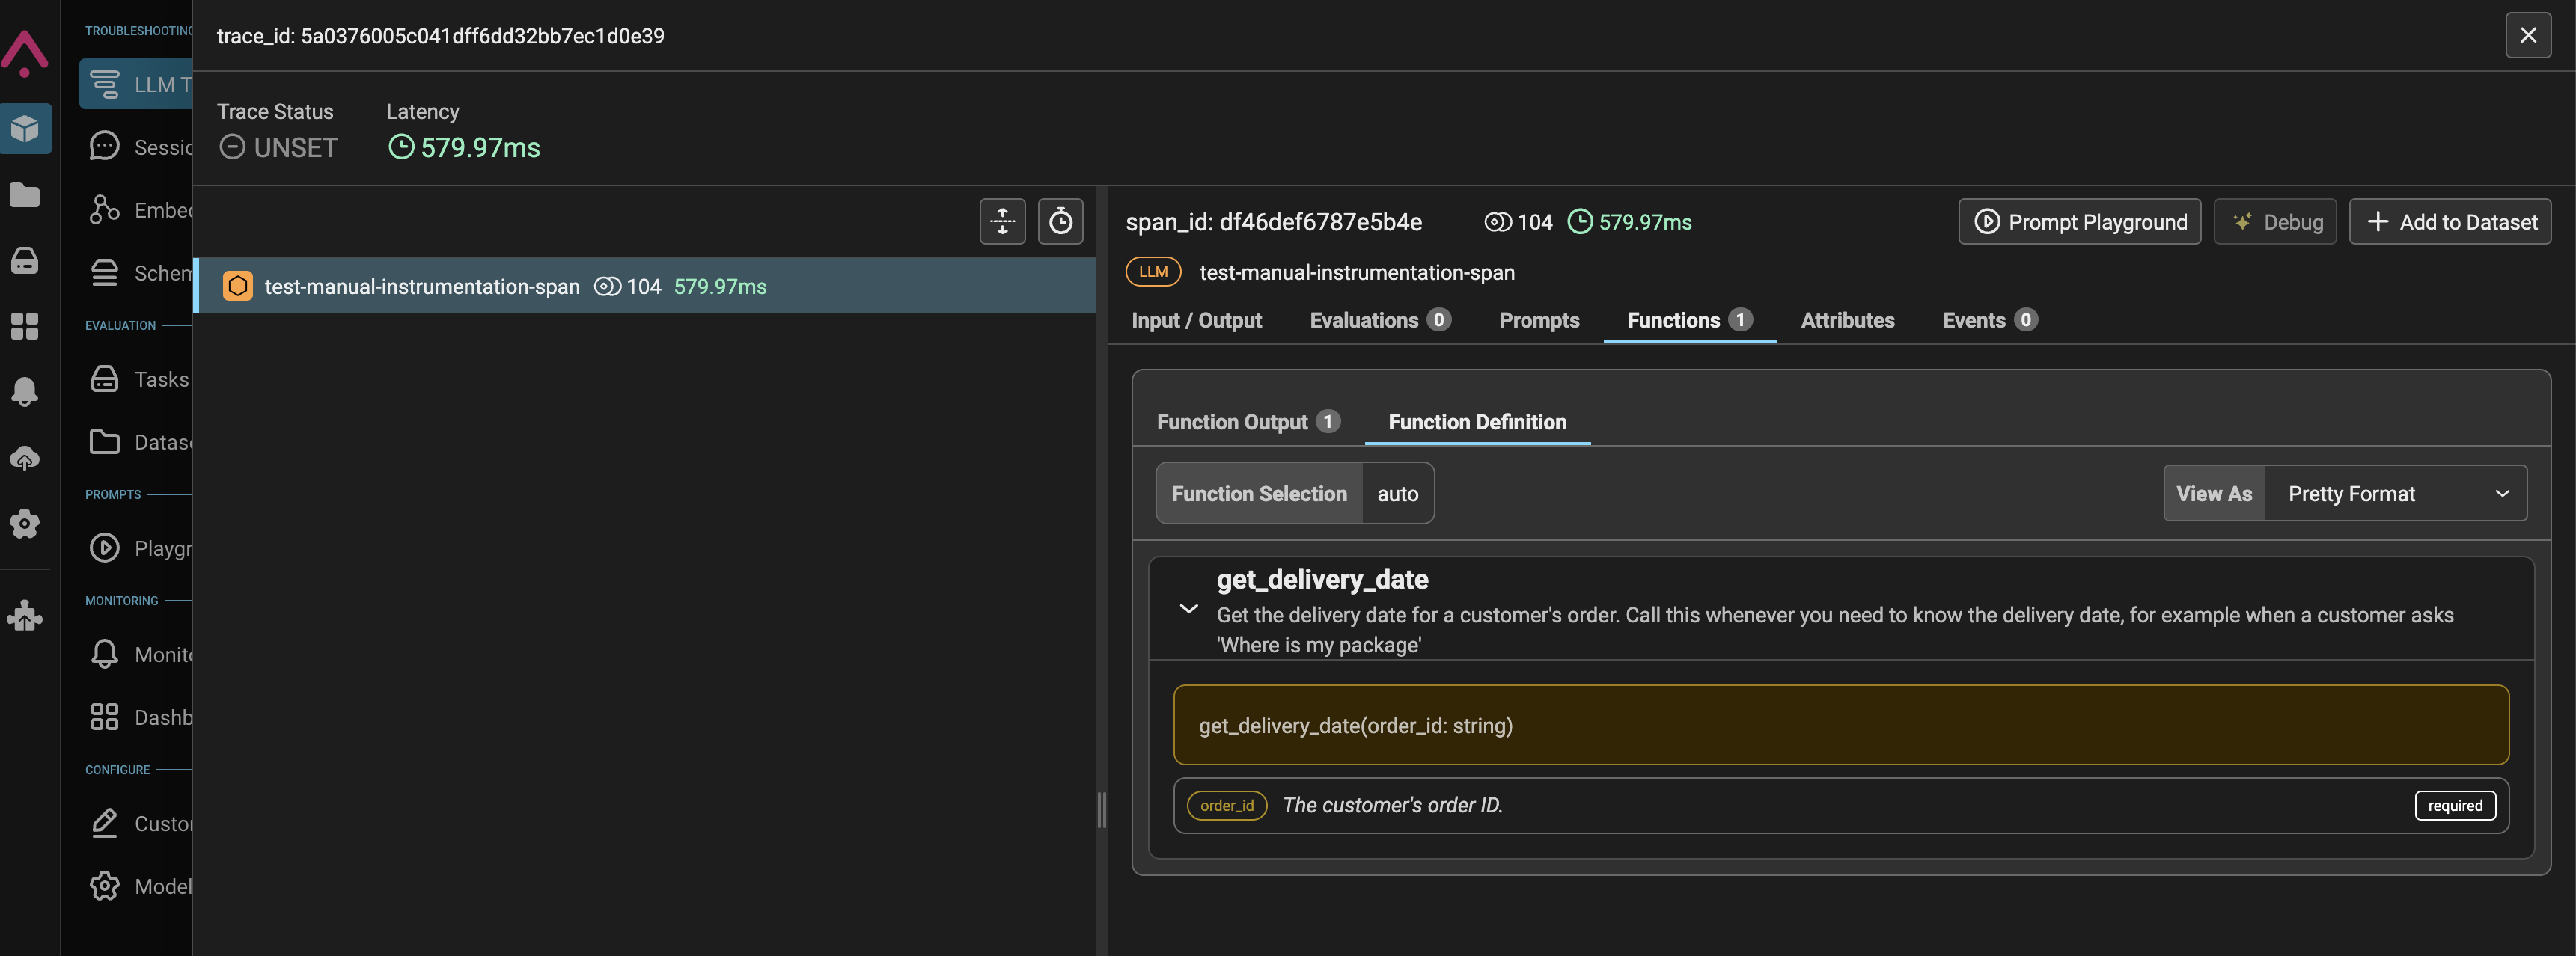

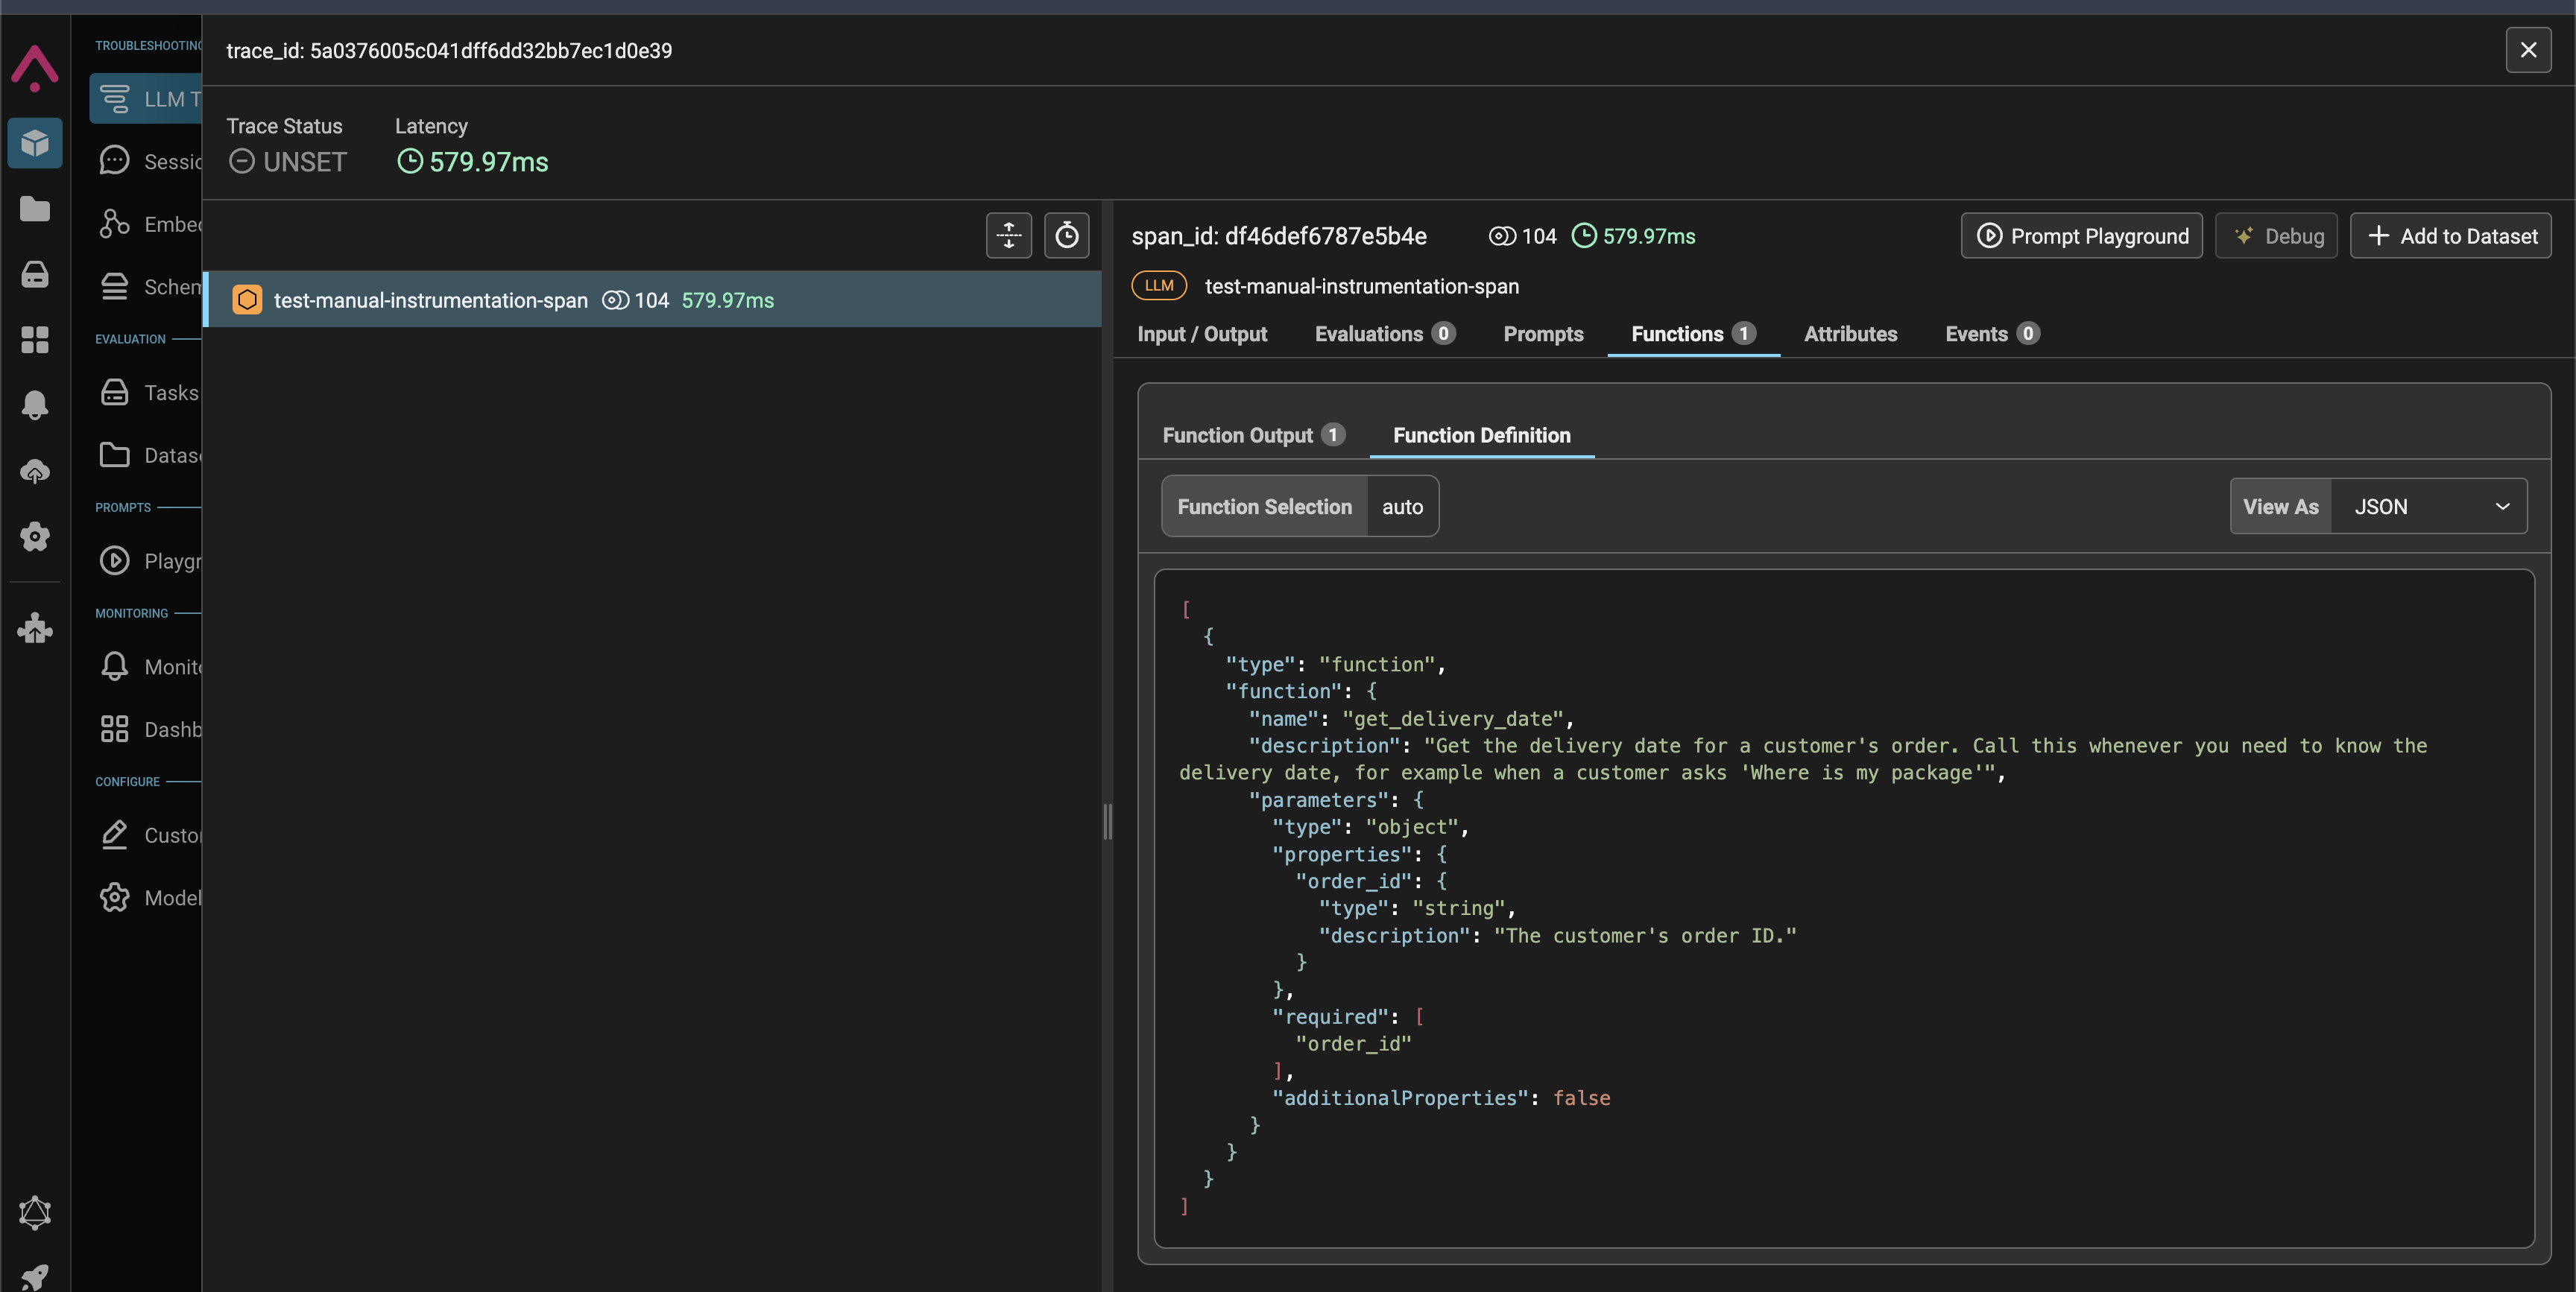

This helper function will instrument the LLM response, including function output:

In [ ]:
def get_json_response(response):
  return json.loads(
    json.dumps(response, default=lambda o: getattr(o, '__dict__', str(o)))
)


def trace_response(span, response):
    span.set_attribute(f"{SpanAttributes.LLM_OUTPUT_MESSAGES}.0.{MessageAttributes.MESSAGE_ROLE}", response.choices[0].message.role)

    # Raw ChatCompletion output
    span.set_attribute(SpanAttributes.OUTPUT_MIME_TYPE, "application/json")
    span.set_attribute(SpanAttributes.OUTPUT_VALUE, json.dumps(get_json_response(response)))

    # Regular LLM text response
    if response.choices[0].message.content is not None:
      span.set_attribute(f"{SpanAttributes.LLM_OUTPUT_MESSAGES}.0.{MessageAttributes.MESSAGE_CONTENT}", response.choices[0].message.content)

    # Function calling json response
    elif response.choices[0].message.tool_calls is not None:
      span.set_attribute(f"{SpanAttributes.LLM_OUTPUT_MESSAGES}.0.{MessageAttributes.MESSAGE_TOOL_CALLS}.0.{ToolCallAttributes.TOOL_CALL_FUNCTION_ARGUMENTS_JSON}", response.choices[0].message.tool_calls[0].function.arguments)
      span.set_attribute(f"{SpanAttributes.LLM_OUTPUT_MESSAGES}.0.{MessageAttributes.MESSAGE_TOOL_CALLS}.0.{ToolCallAttributes.TOOL_CALL_FUNCTION_NAME}", response.choices[0].message.tool_calls[0].function.name)


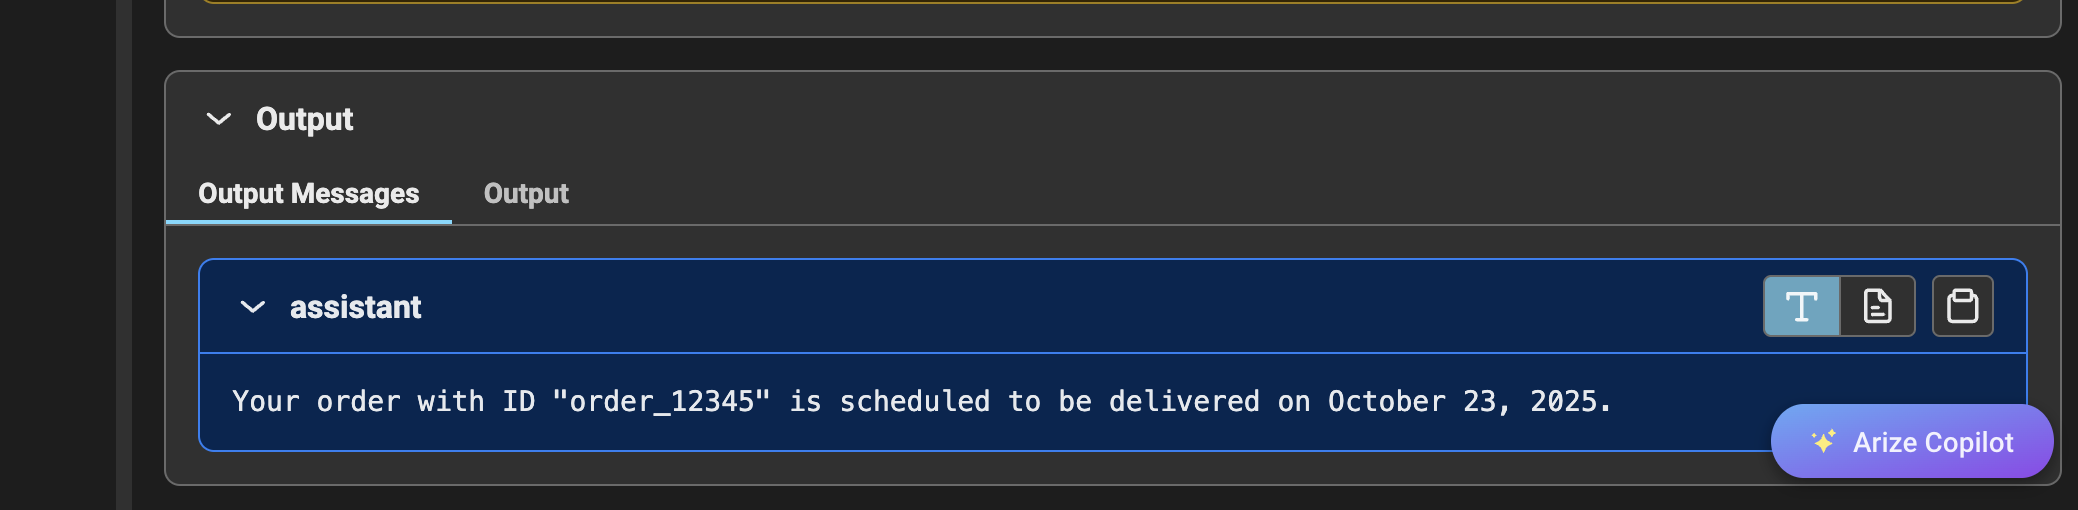

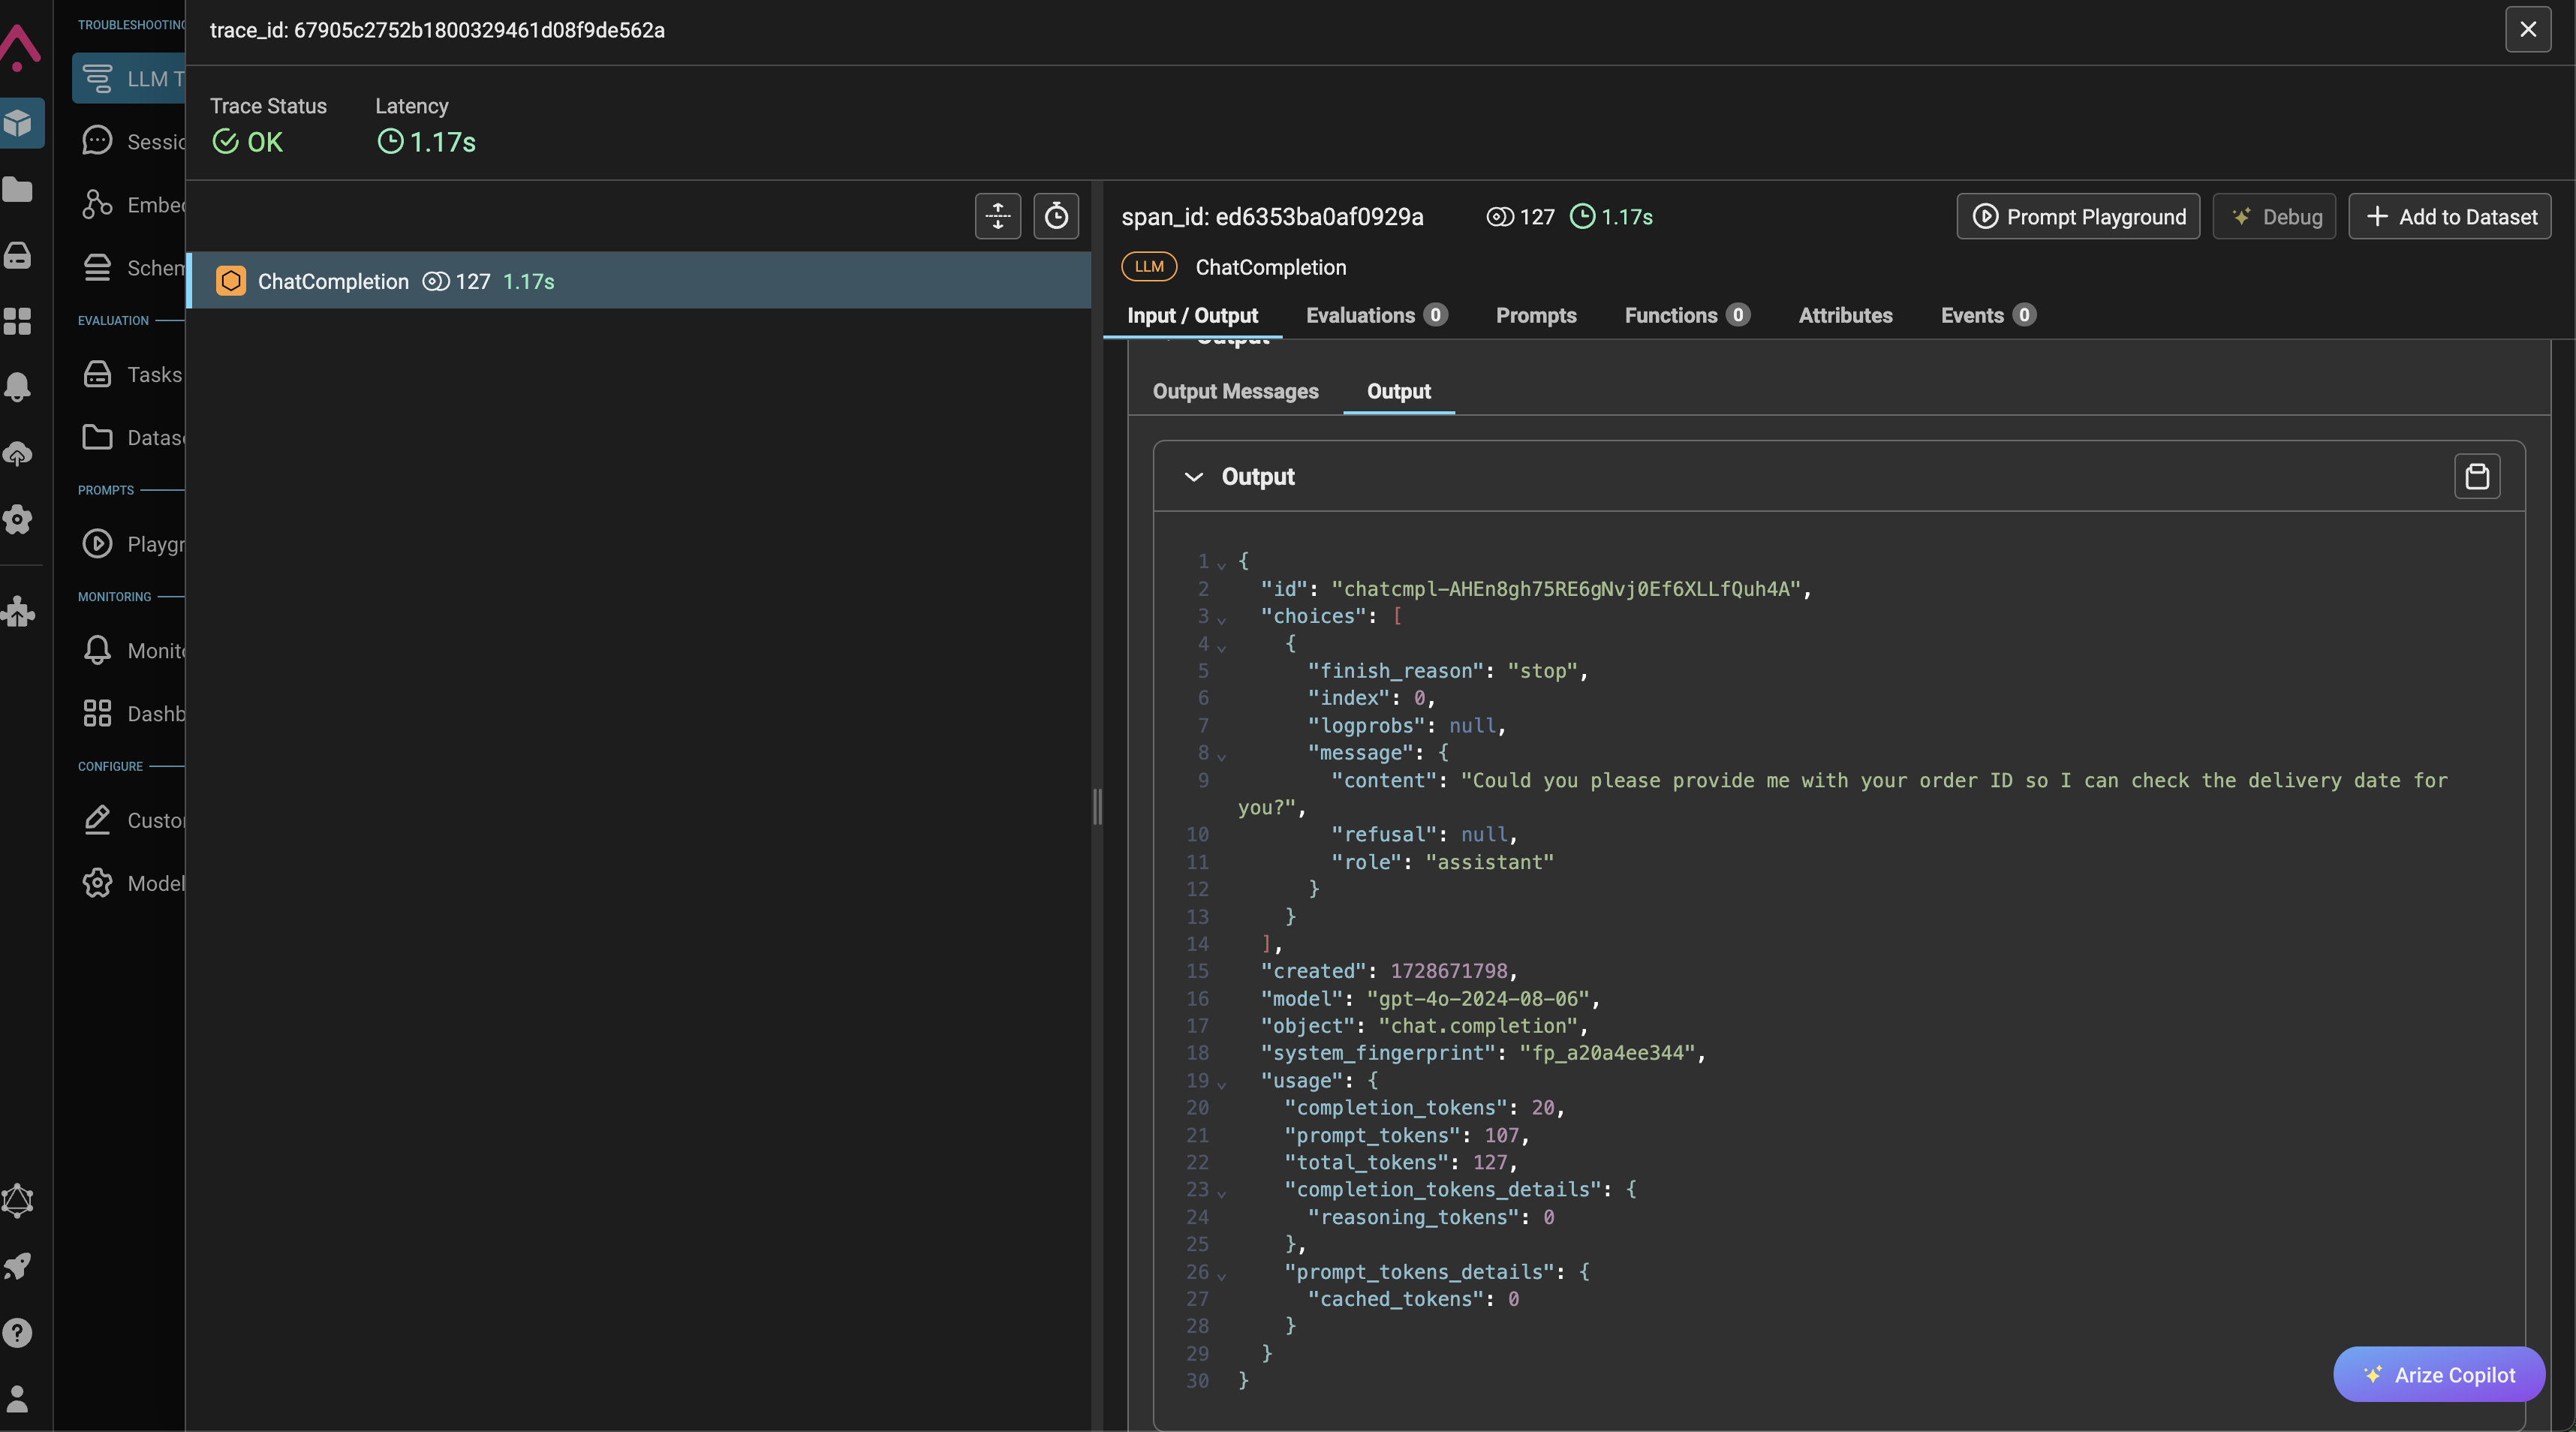

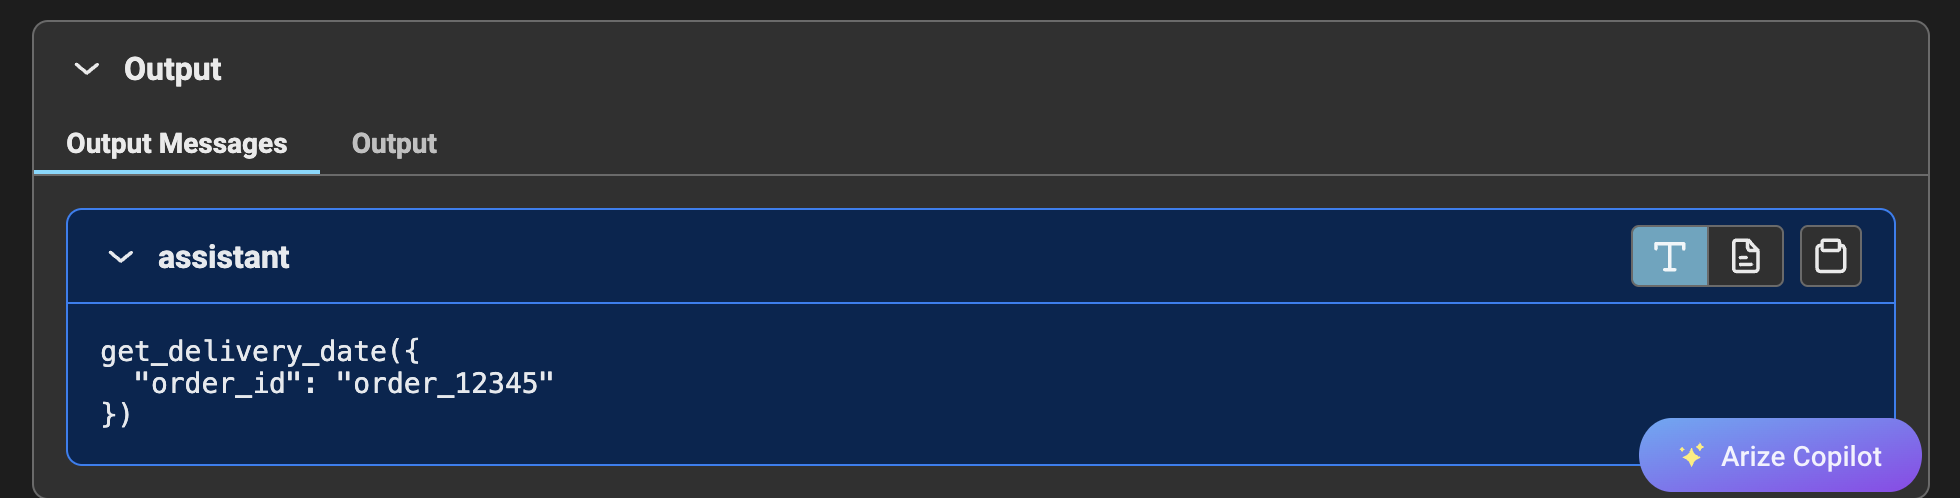

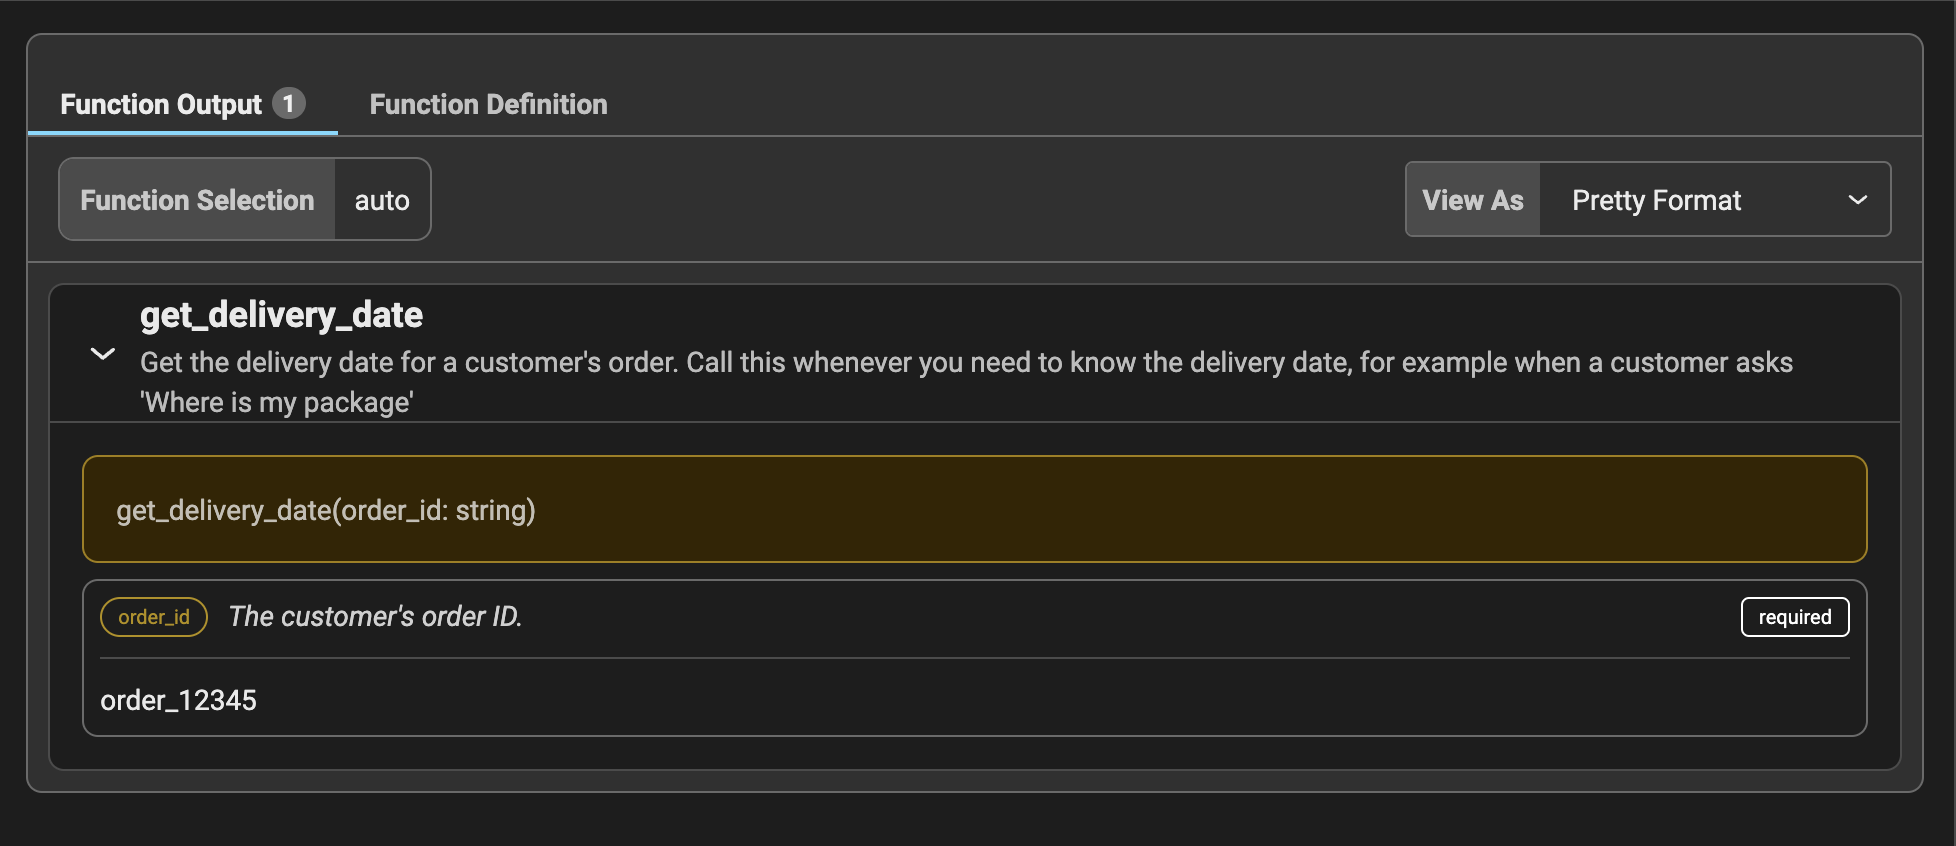

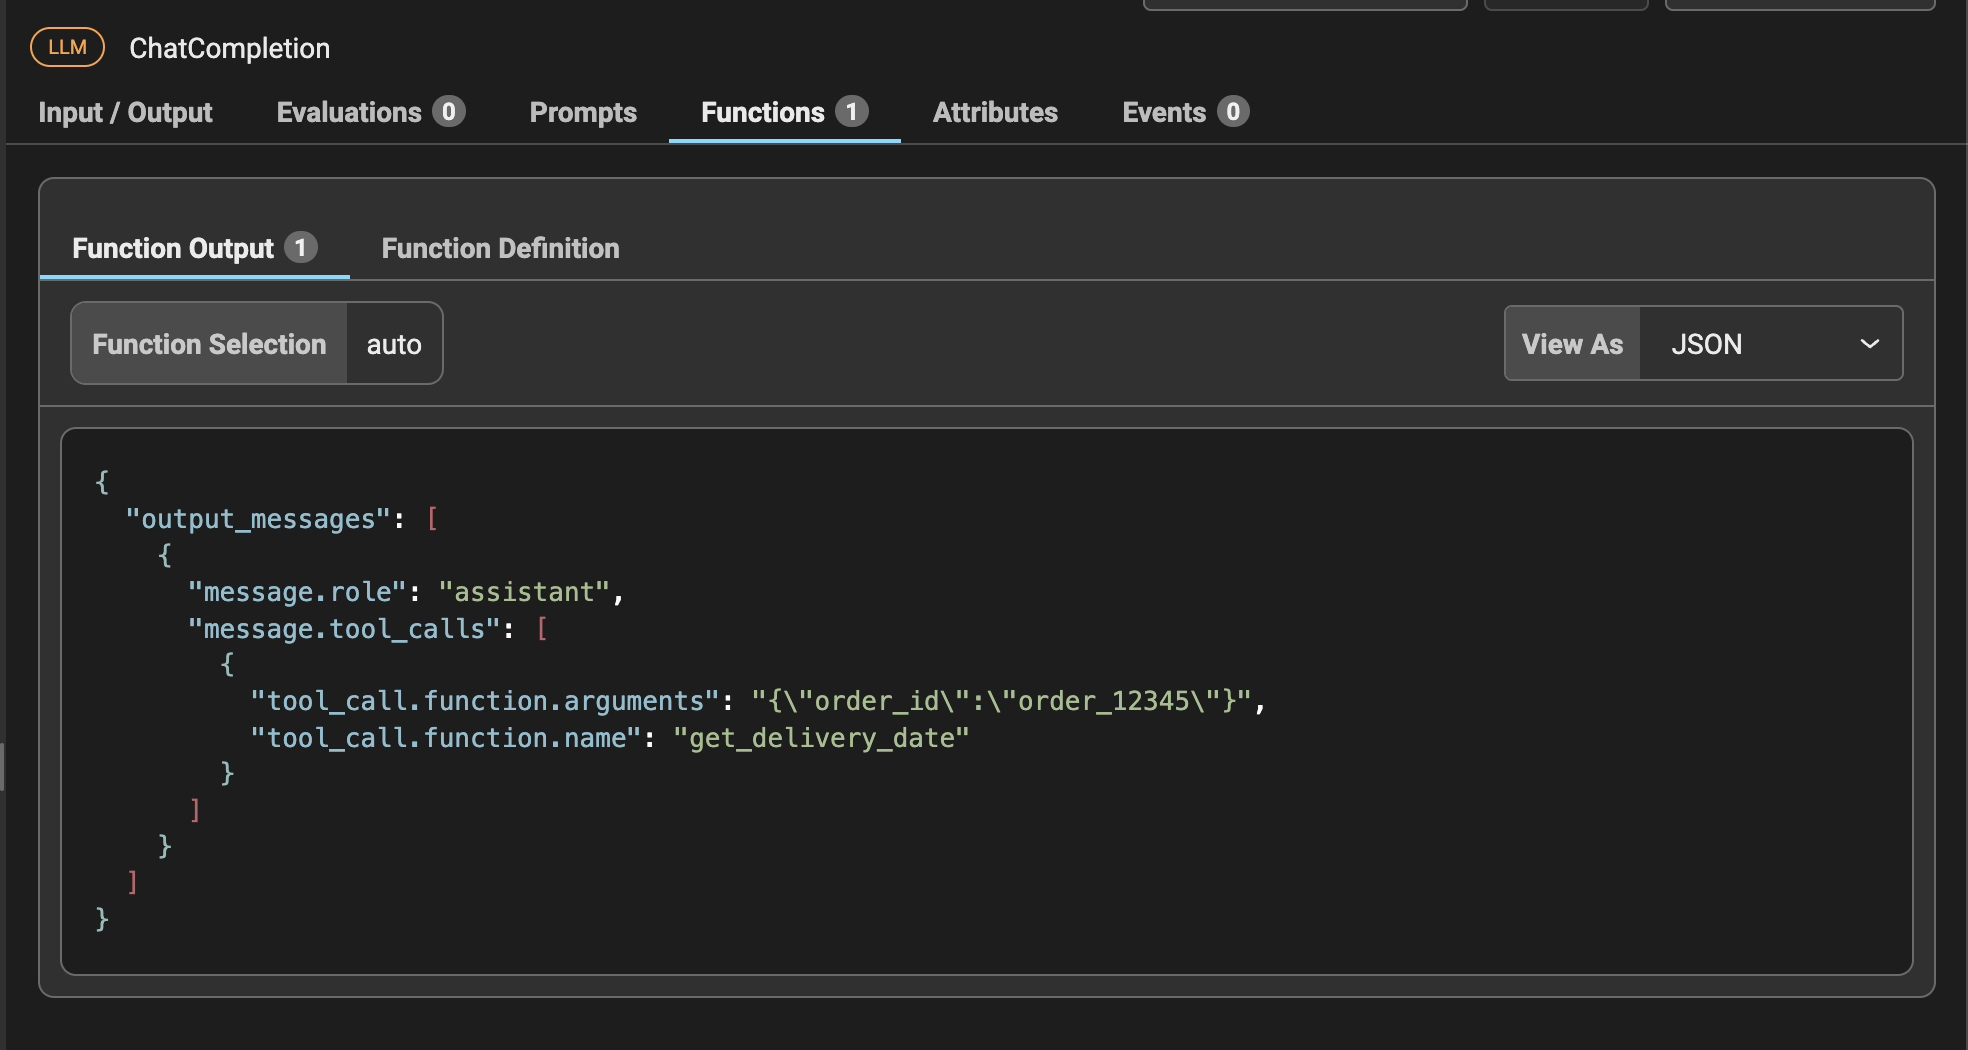

The following helper function will provide the model and LLM span kind such that the model details can be loaded into the [Prompt Playground](https://docs.arize.com/arize/llm-playground/prompt-playground):

In [ ]:
def trace_span_metadata(span, model):
  span.set_attribute(SpanAttributes.LLM_MODEL_NAME, model)
  span.set_attribute(SpanAttributes.OPENINFERENCE_SPAN_KIND, "LLM")

# Set Up Open AI Client

In [ ]:
os.environ["OPENAI_API_KEY"] = getpass("Enter your Open AI API key: ")
client = OpenAI()

# Define Tools

The following example is based on the [Open AI developer docs](https://platform.openai.com/docs/guides/function-calling).

In [ ]:
# This is the function that we want the model to be able to call
def get_delivery_date(order_id: str) -> str:
  delivery_date = random.randint(0, 30)
  return f"Oct {delivery_date}, 2025"

In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_delivery_date",
            "description": "Get the delivery date for a customer's order. "
            + "Call this whenever you need to know the delivery date, for "
            + "example when a customer asks 'Where is my package'",
            "parameters": {
                "type": "object",
                "properties": {
                    "order_id": {
                        "type": "string",
                        "description": "The customer's order ID.",
                    },
                },
                "required": ["order_id"],
                "additionalProperties": False,
            },
        },
    }
]

# LLM Chats with User to Get Order ID




In [ ]:
messages = [
    # Define system message
     {"role": "system", "content": "You are a helpful customer support assistant. Use the supplied tools to assist the user."},
    # Simulate user message
    {"role": "user", "content": "Hi, can you tell me the delivery date for my order?"}
]

In [ ]:
tracer = trace.get_tracer(__name__)
with tracer.start_as_current_span("llm-asks-for-order-id") as span:
  response = openai.chat.completions.create(
      model=model,
      messages=messages,
      tools=tools,
  )
  trace_input_and_messages(span, messages)
  trace_response(span, response)
  trace_function_definition(span, tools)
  trace_span_metadata(span, model)

messages.append({"role": "assistant", "content": response.choices[0].message.content})
messages

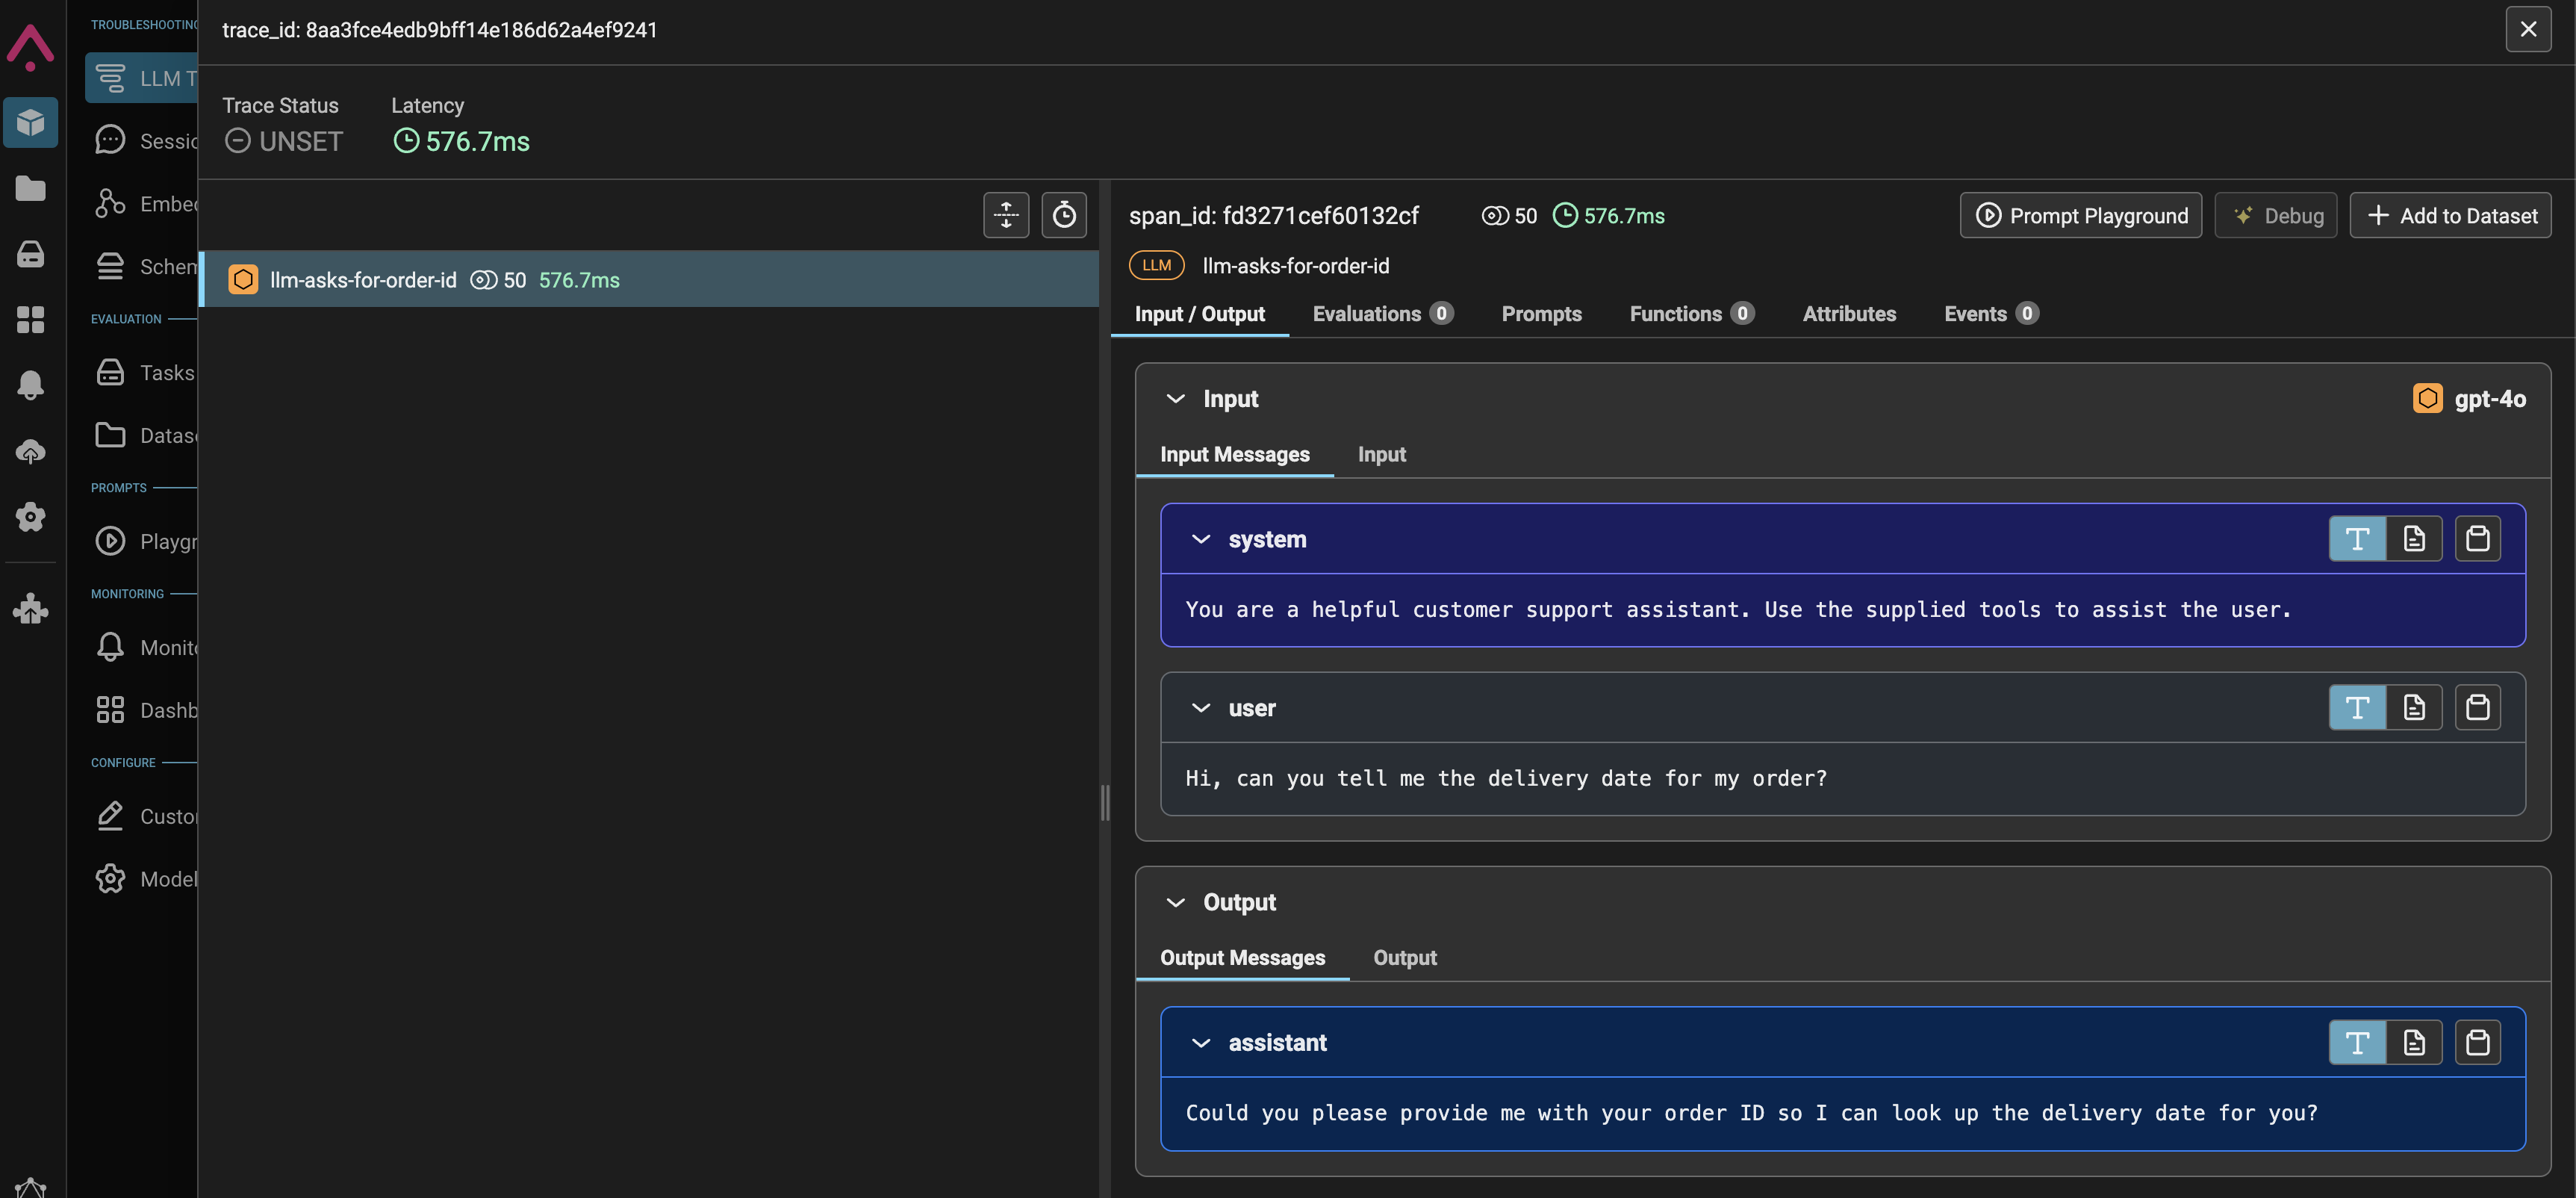

# LLM Requests to Make Function Call with Customer Order ID

In [ ]:
# Simulate user message
messages.append({"role": "user", "content": "i think it is order_12345"})
messages

In [ ]:
client = OpenAI()
tracer = trace.get_tracer(__name__)
with tracer.start_as_current_span("llm-provides-parameters-for-function-call") as span:
  tool_calls_response = client.chat.completions.create(
      model='gpt-4o',
      messages=messages,
      tools=tools
  )
  trace_input_and_messages(span, messages)
  trace_response(span, tool_calls_response)
  trace_function_definition(span, tools)
  trace_span_metadata(span, model)

tool_call_dict = dict(tool_calls_response.choices[0].message.tool_calls[0])
tool_call_dict["function"] = dict(tool_call_dict["function"])
messages.append({
    "role": tool_calls_response.choices[0].message.role,
    "tool_calls": [tool_call_dict]
    })
messages

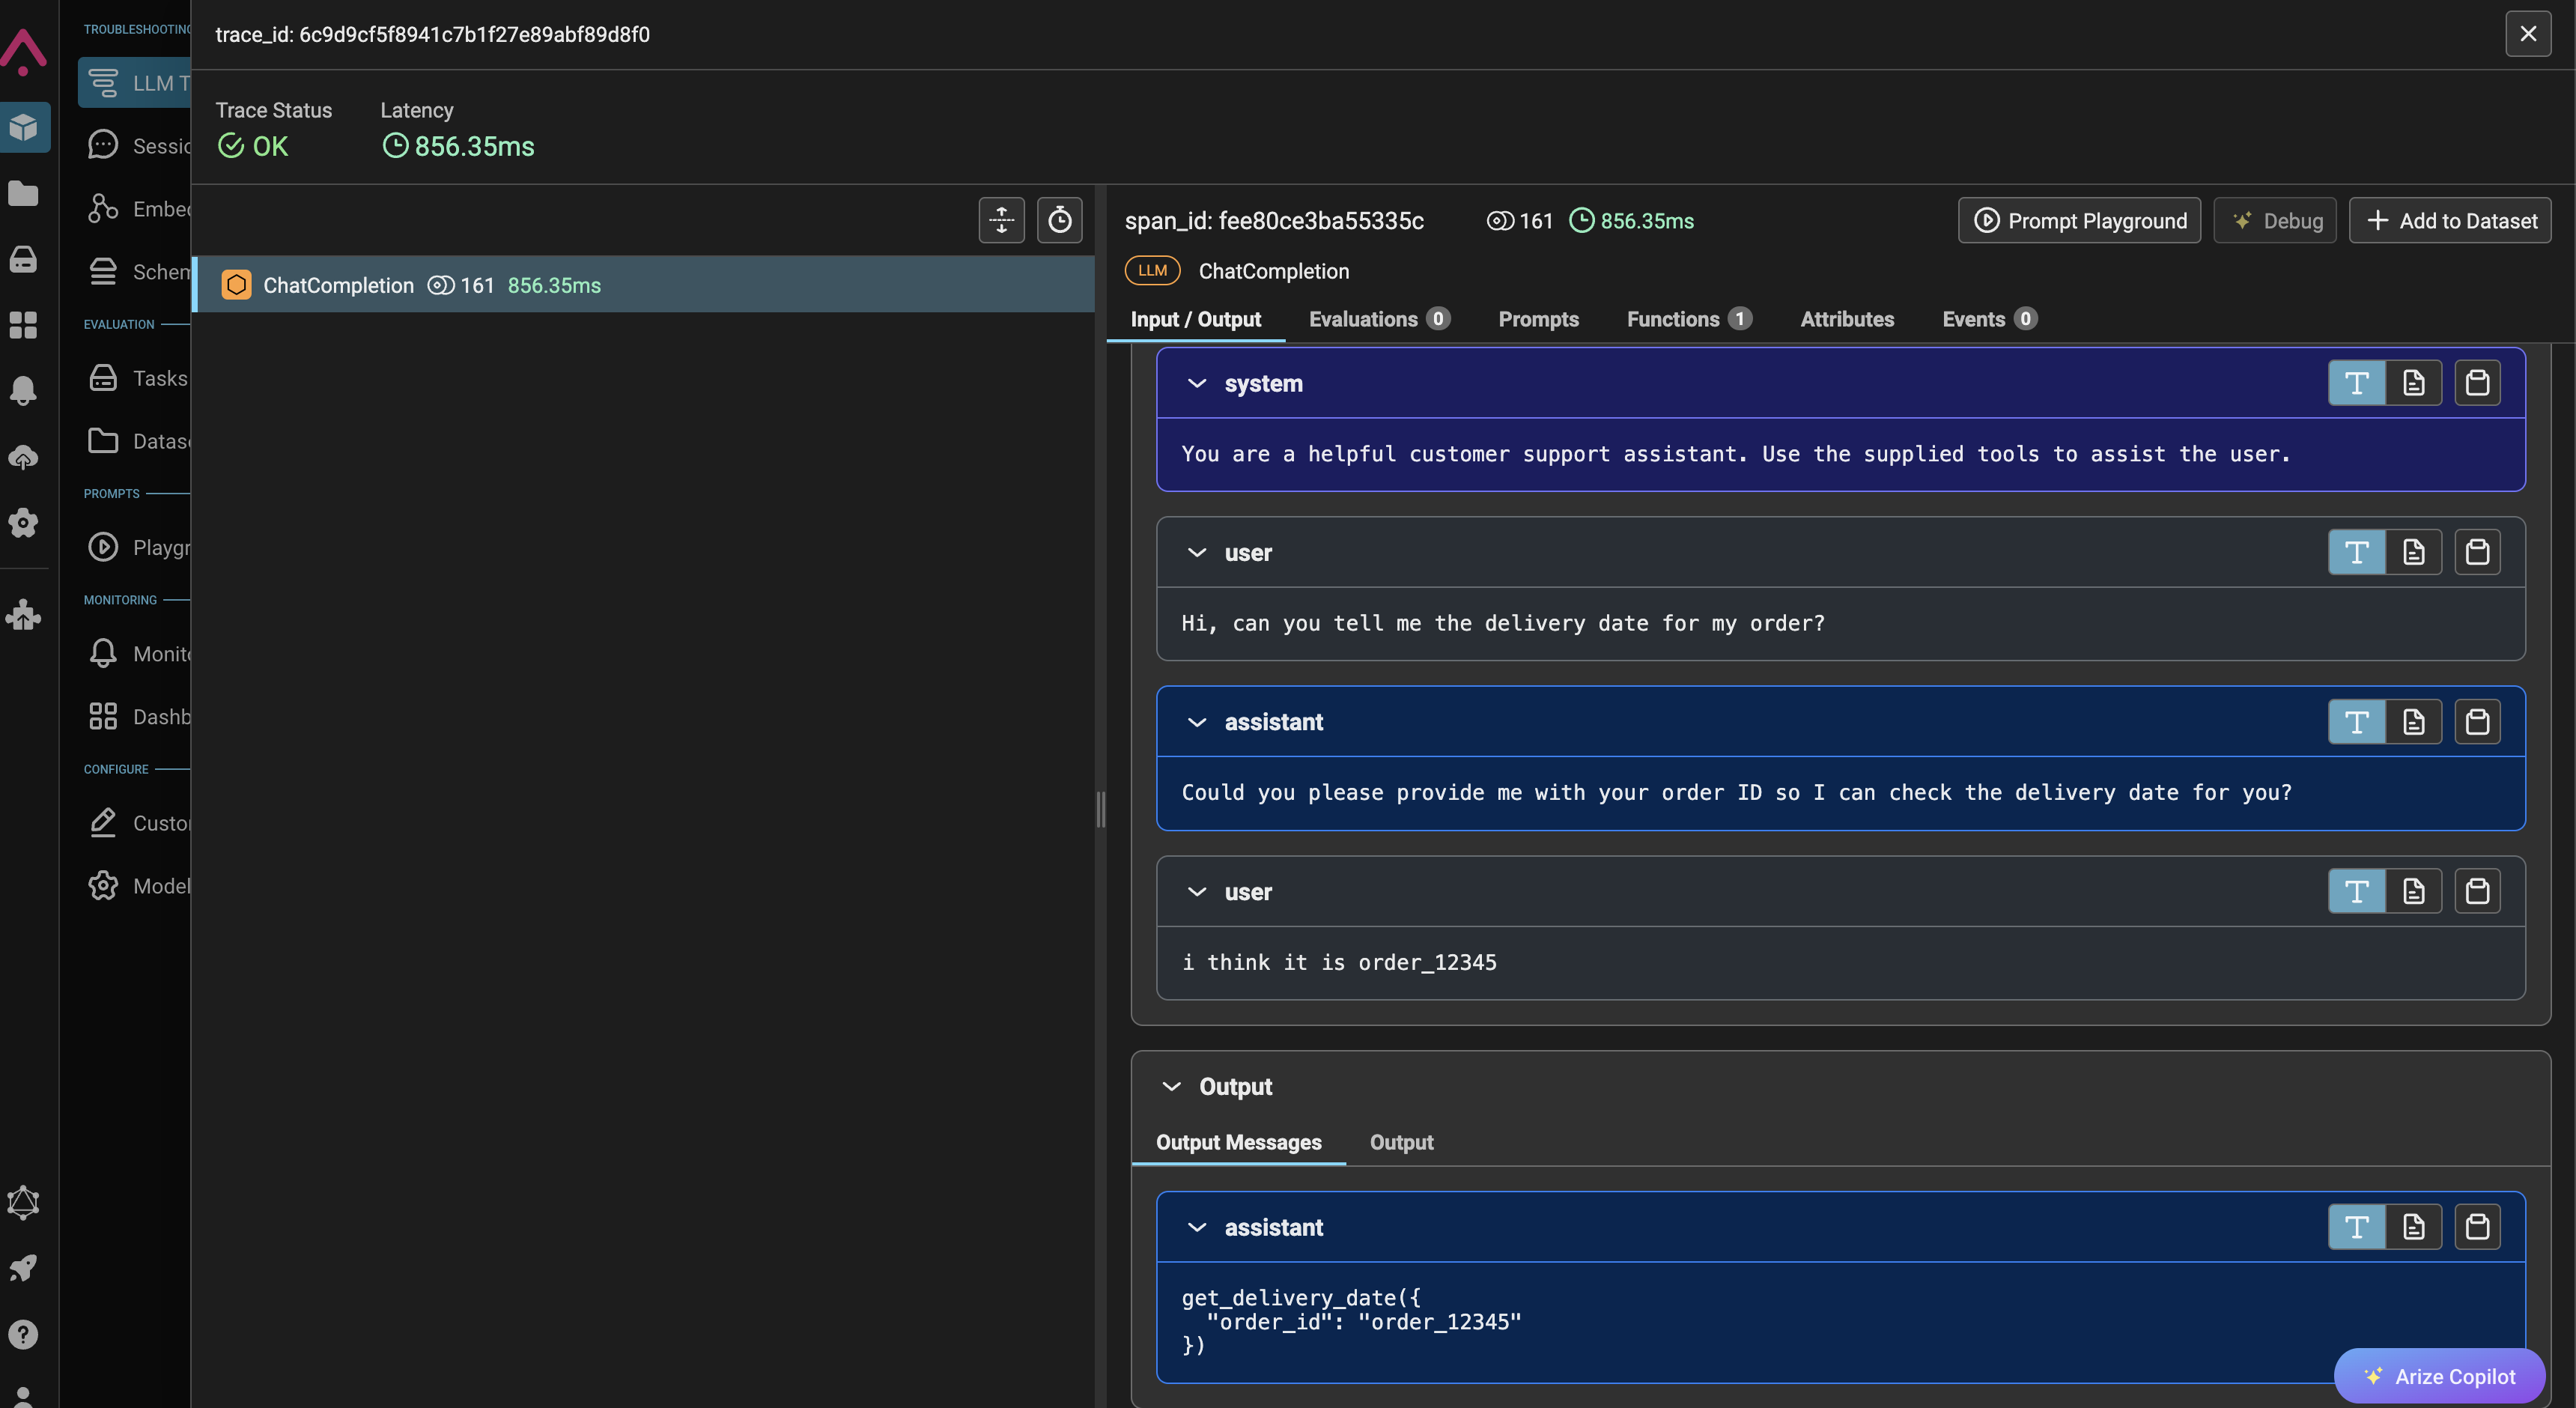

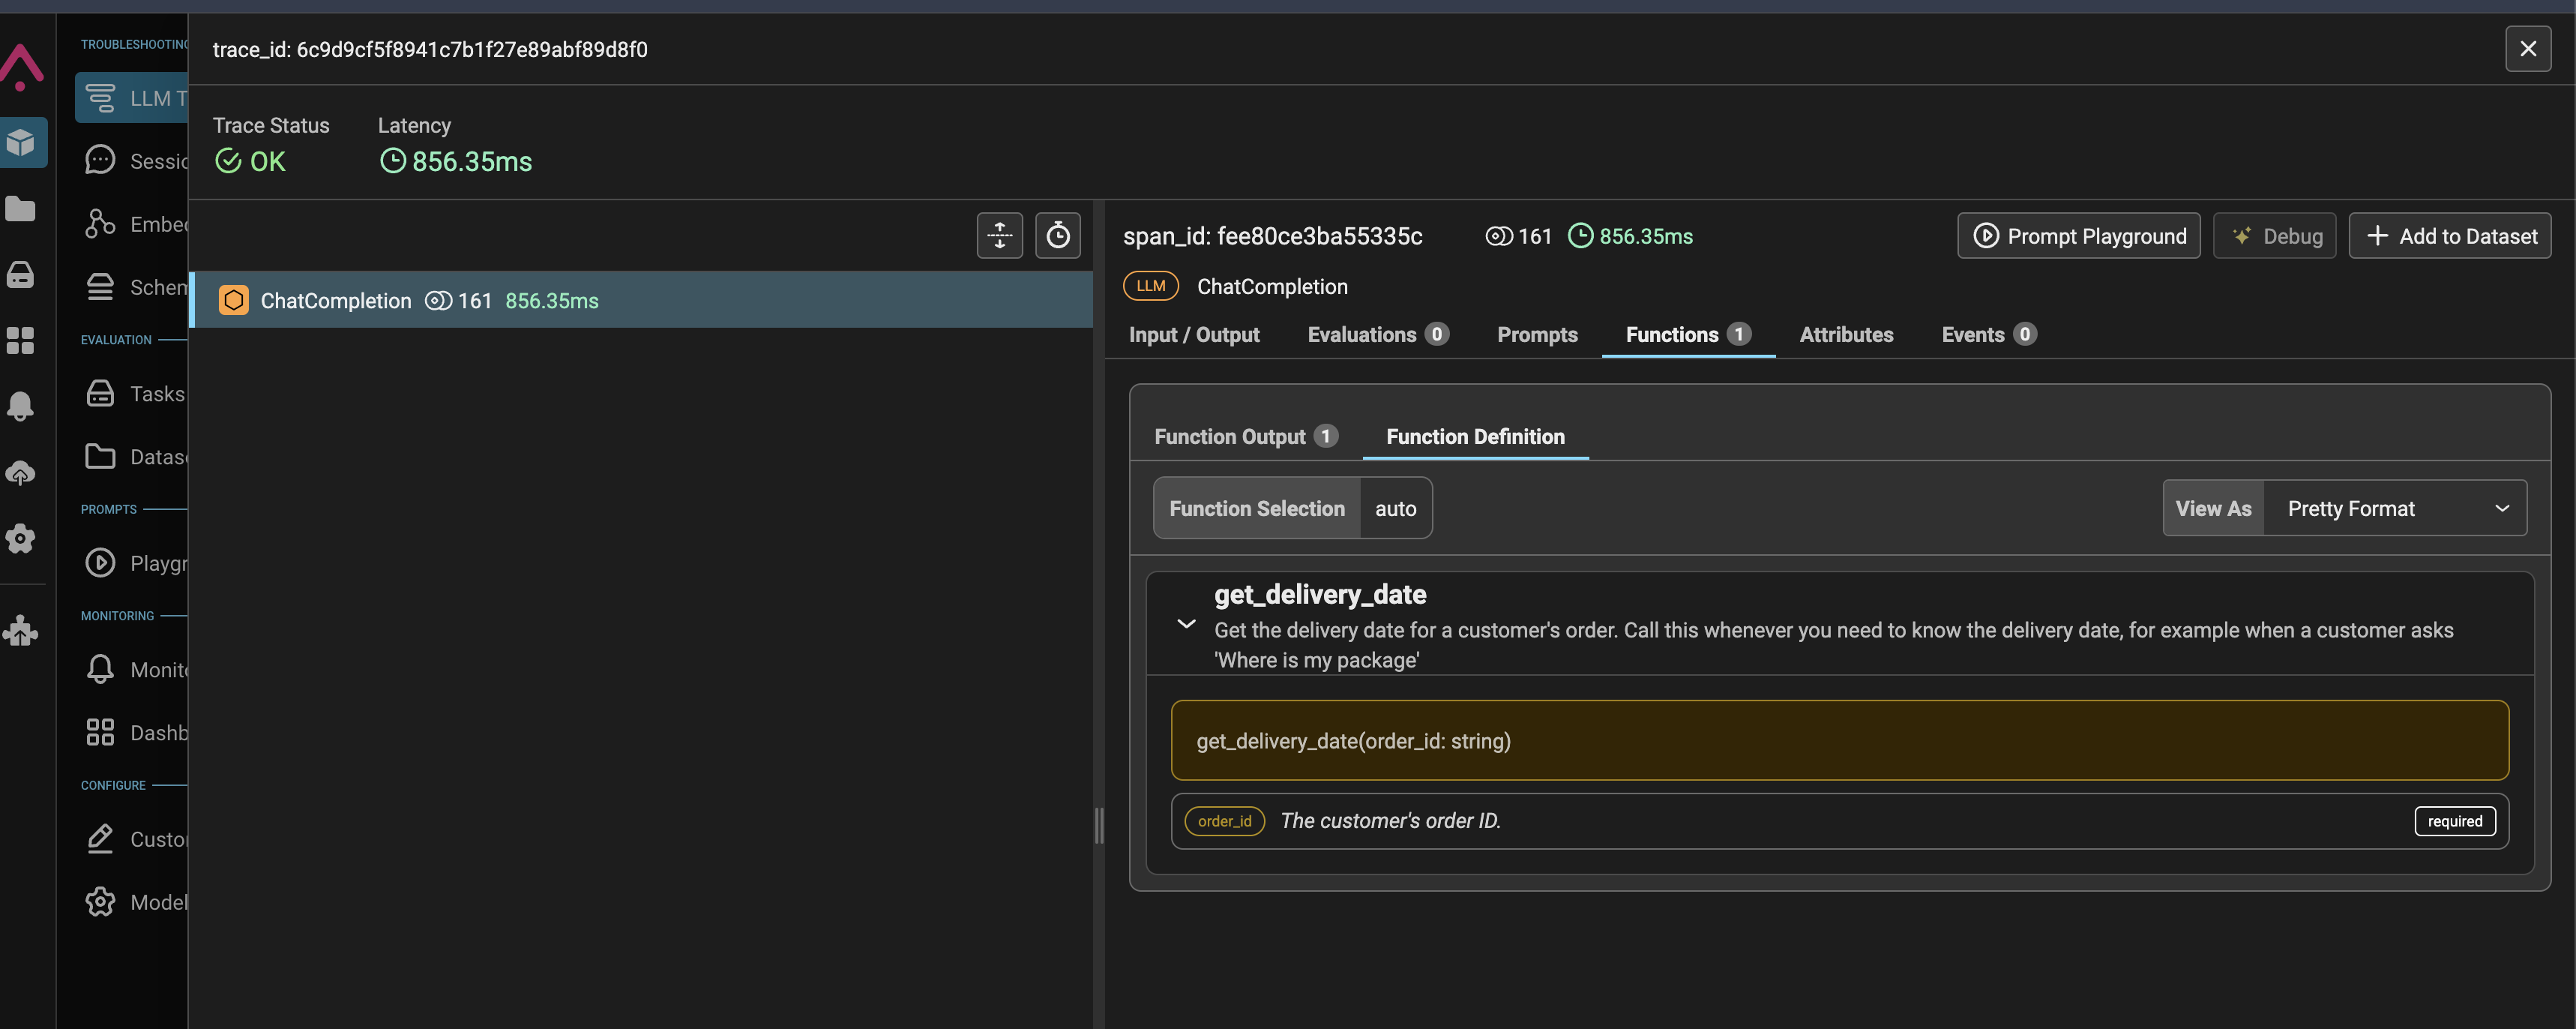

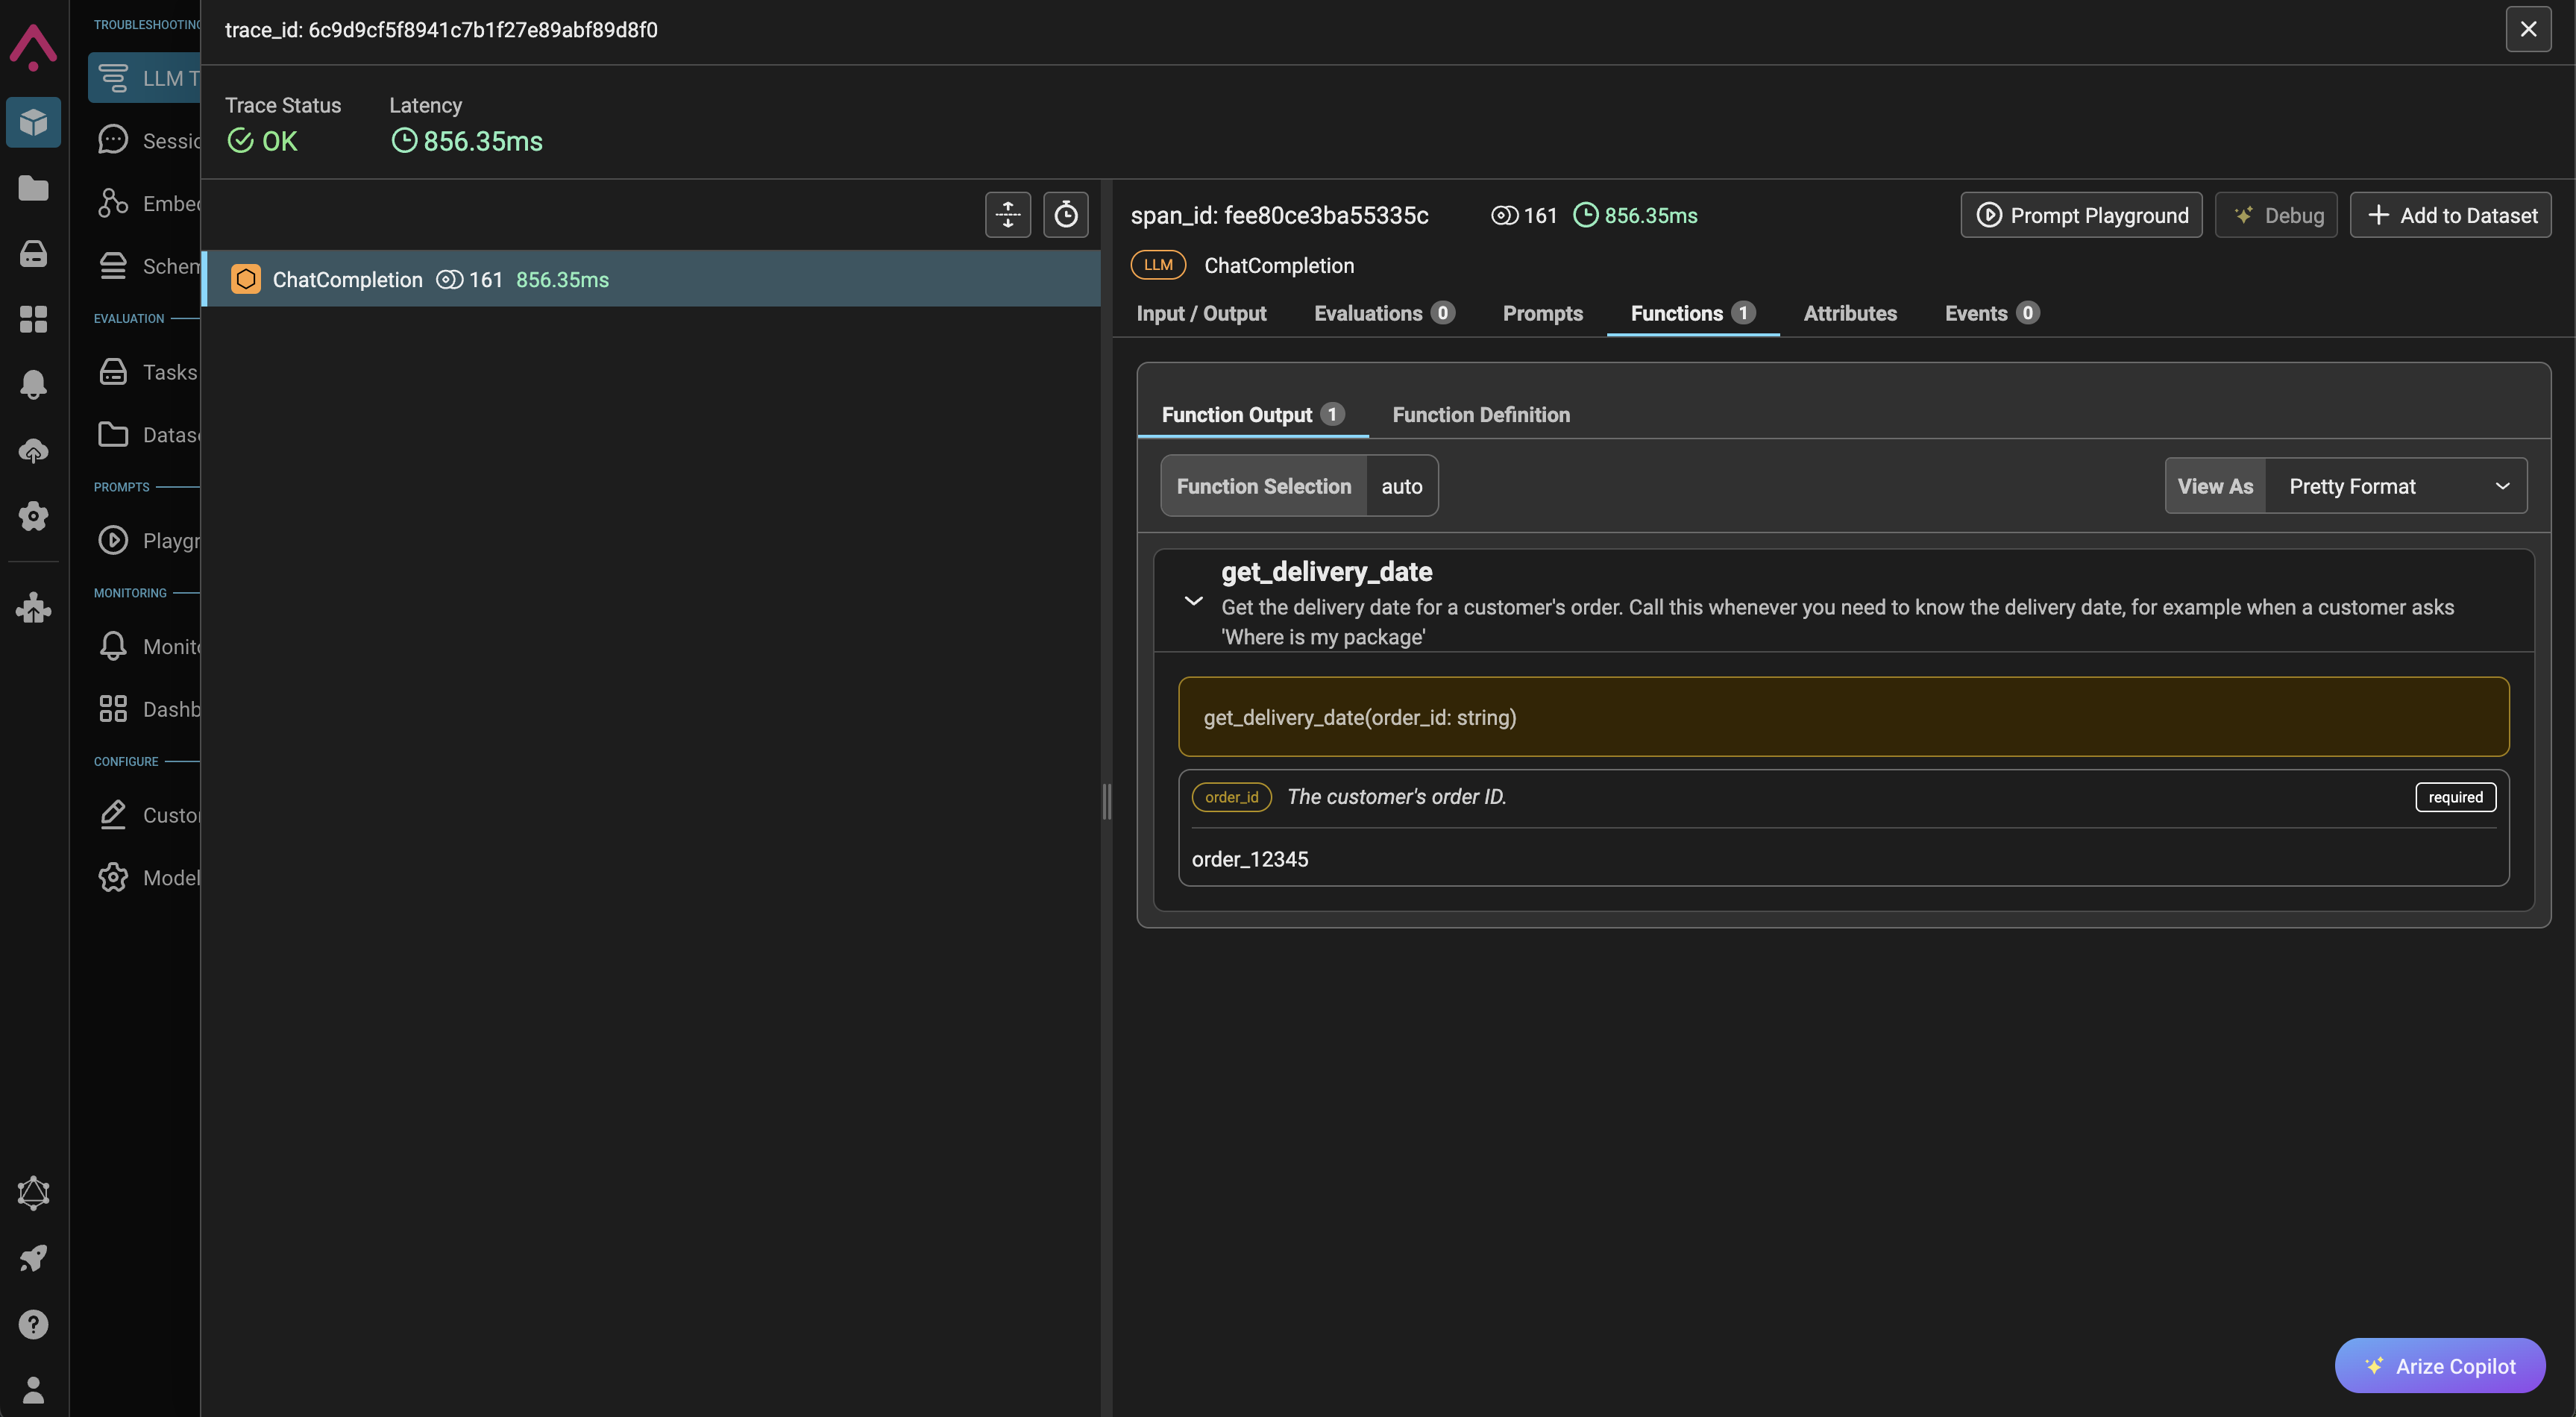

# Call Function with Parameters from LLM

In [ ]:
tool_call = tool_calls_response.choices[0].message.tool_calls[0]
order_id = json.loads(tool_call.function.arguments).get('order_id')
delivery_date = get_delivery_date(order_id)
delivery_date

# Append Function Output to Messages



In [ ]:
function_call_result_message = {
  "role": "tool",
  "content": json.dumps({
      "order_id": order_id,
      "delivery_date": delivery_date
  }),
  "tool_call_id": tool_call.id
}

messages.append(function_call_result_message)
messages

# LLM Uses Function Output to Reply to User Message

In [ ]:
client = OpenAI()
tracer = trace.get_tracer(__name__)
with tracer.start_as_current_span("llm-uses-function-output-to-reply-to-user") as span:
  response = client.chat.completions.create(
      model="gpt-4o",
      messages=messages,
      tools=tools
  )
  trace_input_and_messages(span, messages)
  trace_response(span, response)
  trace_function_definition(span, tools)
  trace_span_metadata(span, model)

messages.append({"role": "assistant", "content": response.choices[0].message.content})
messages

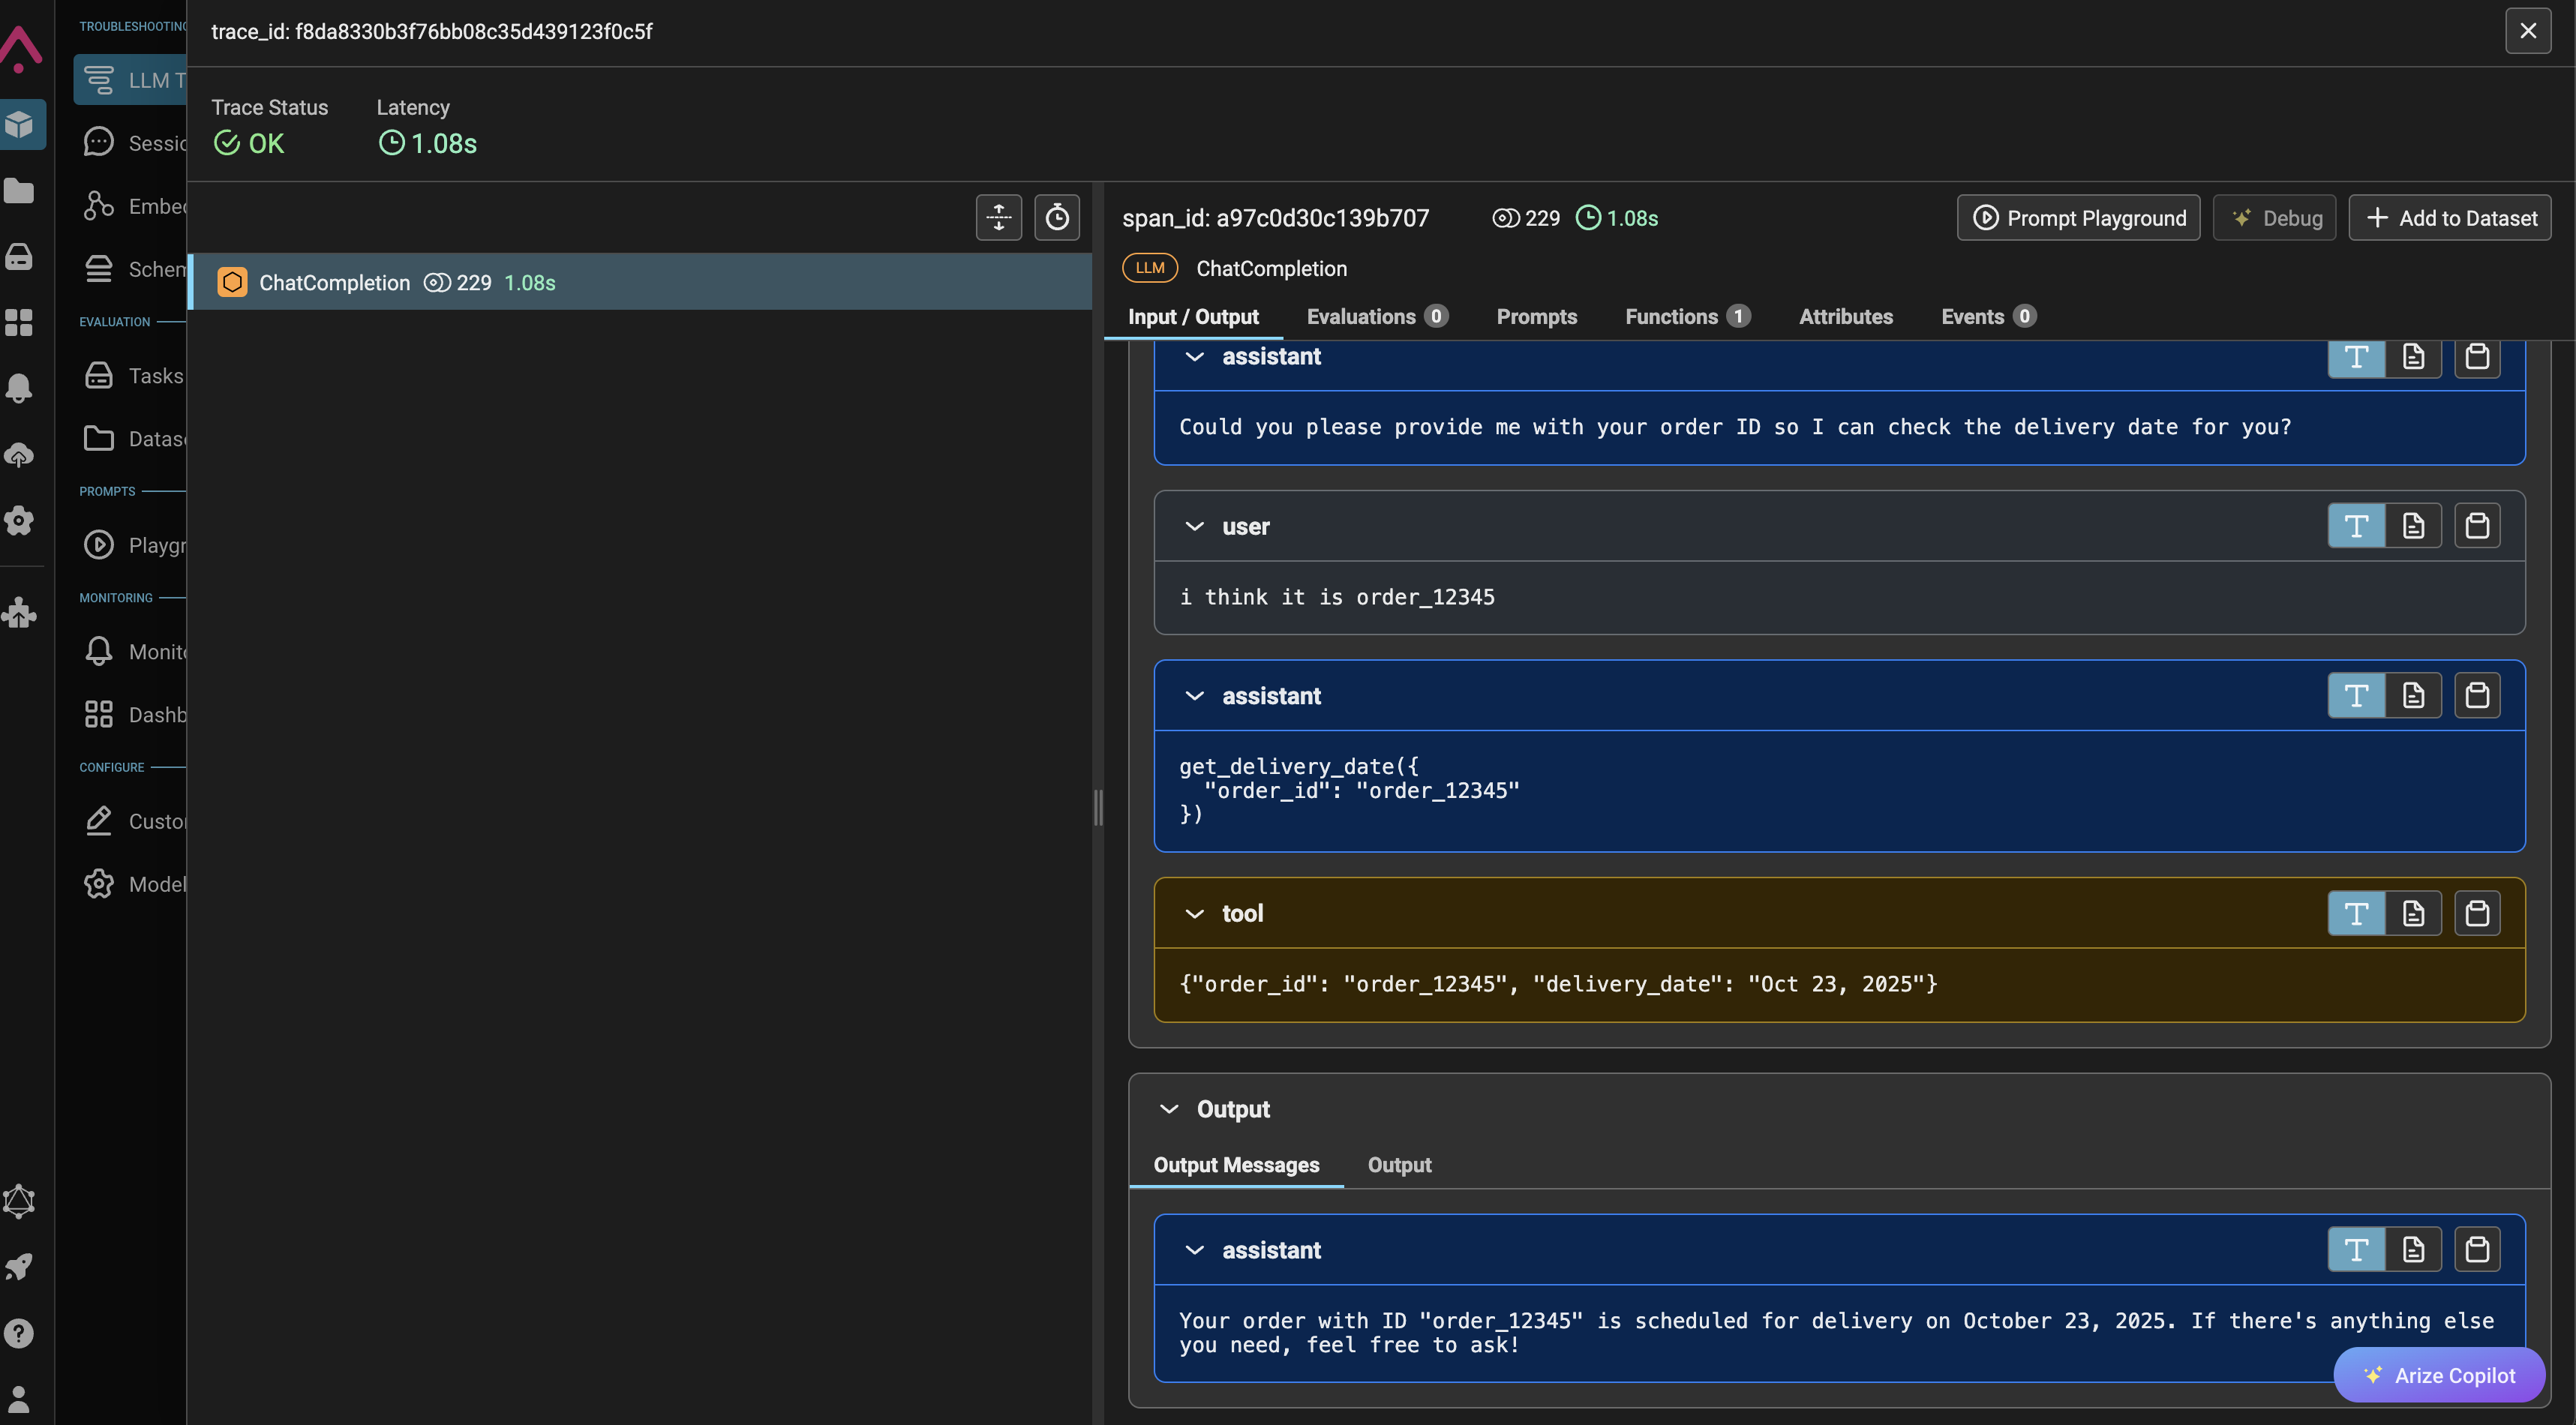

# Load Span into Prompt Playground

Load any of the spans in the [Prompt Playground](https://docs.arize.com/arize/llm-playground/prompt-playground), and modify the messages or function definitions to see how the LLM's response changes!

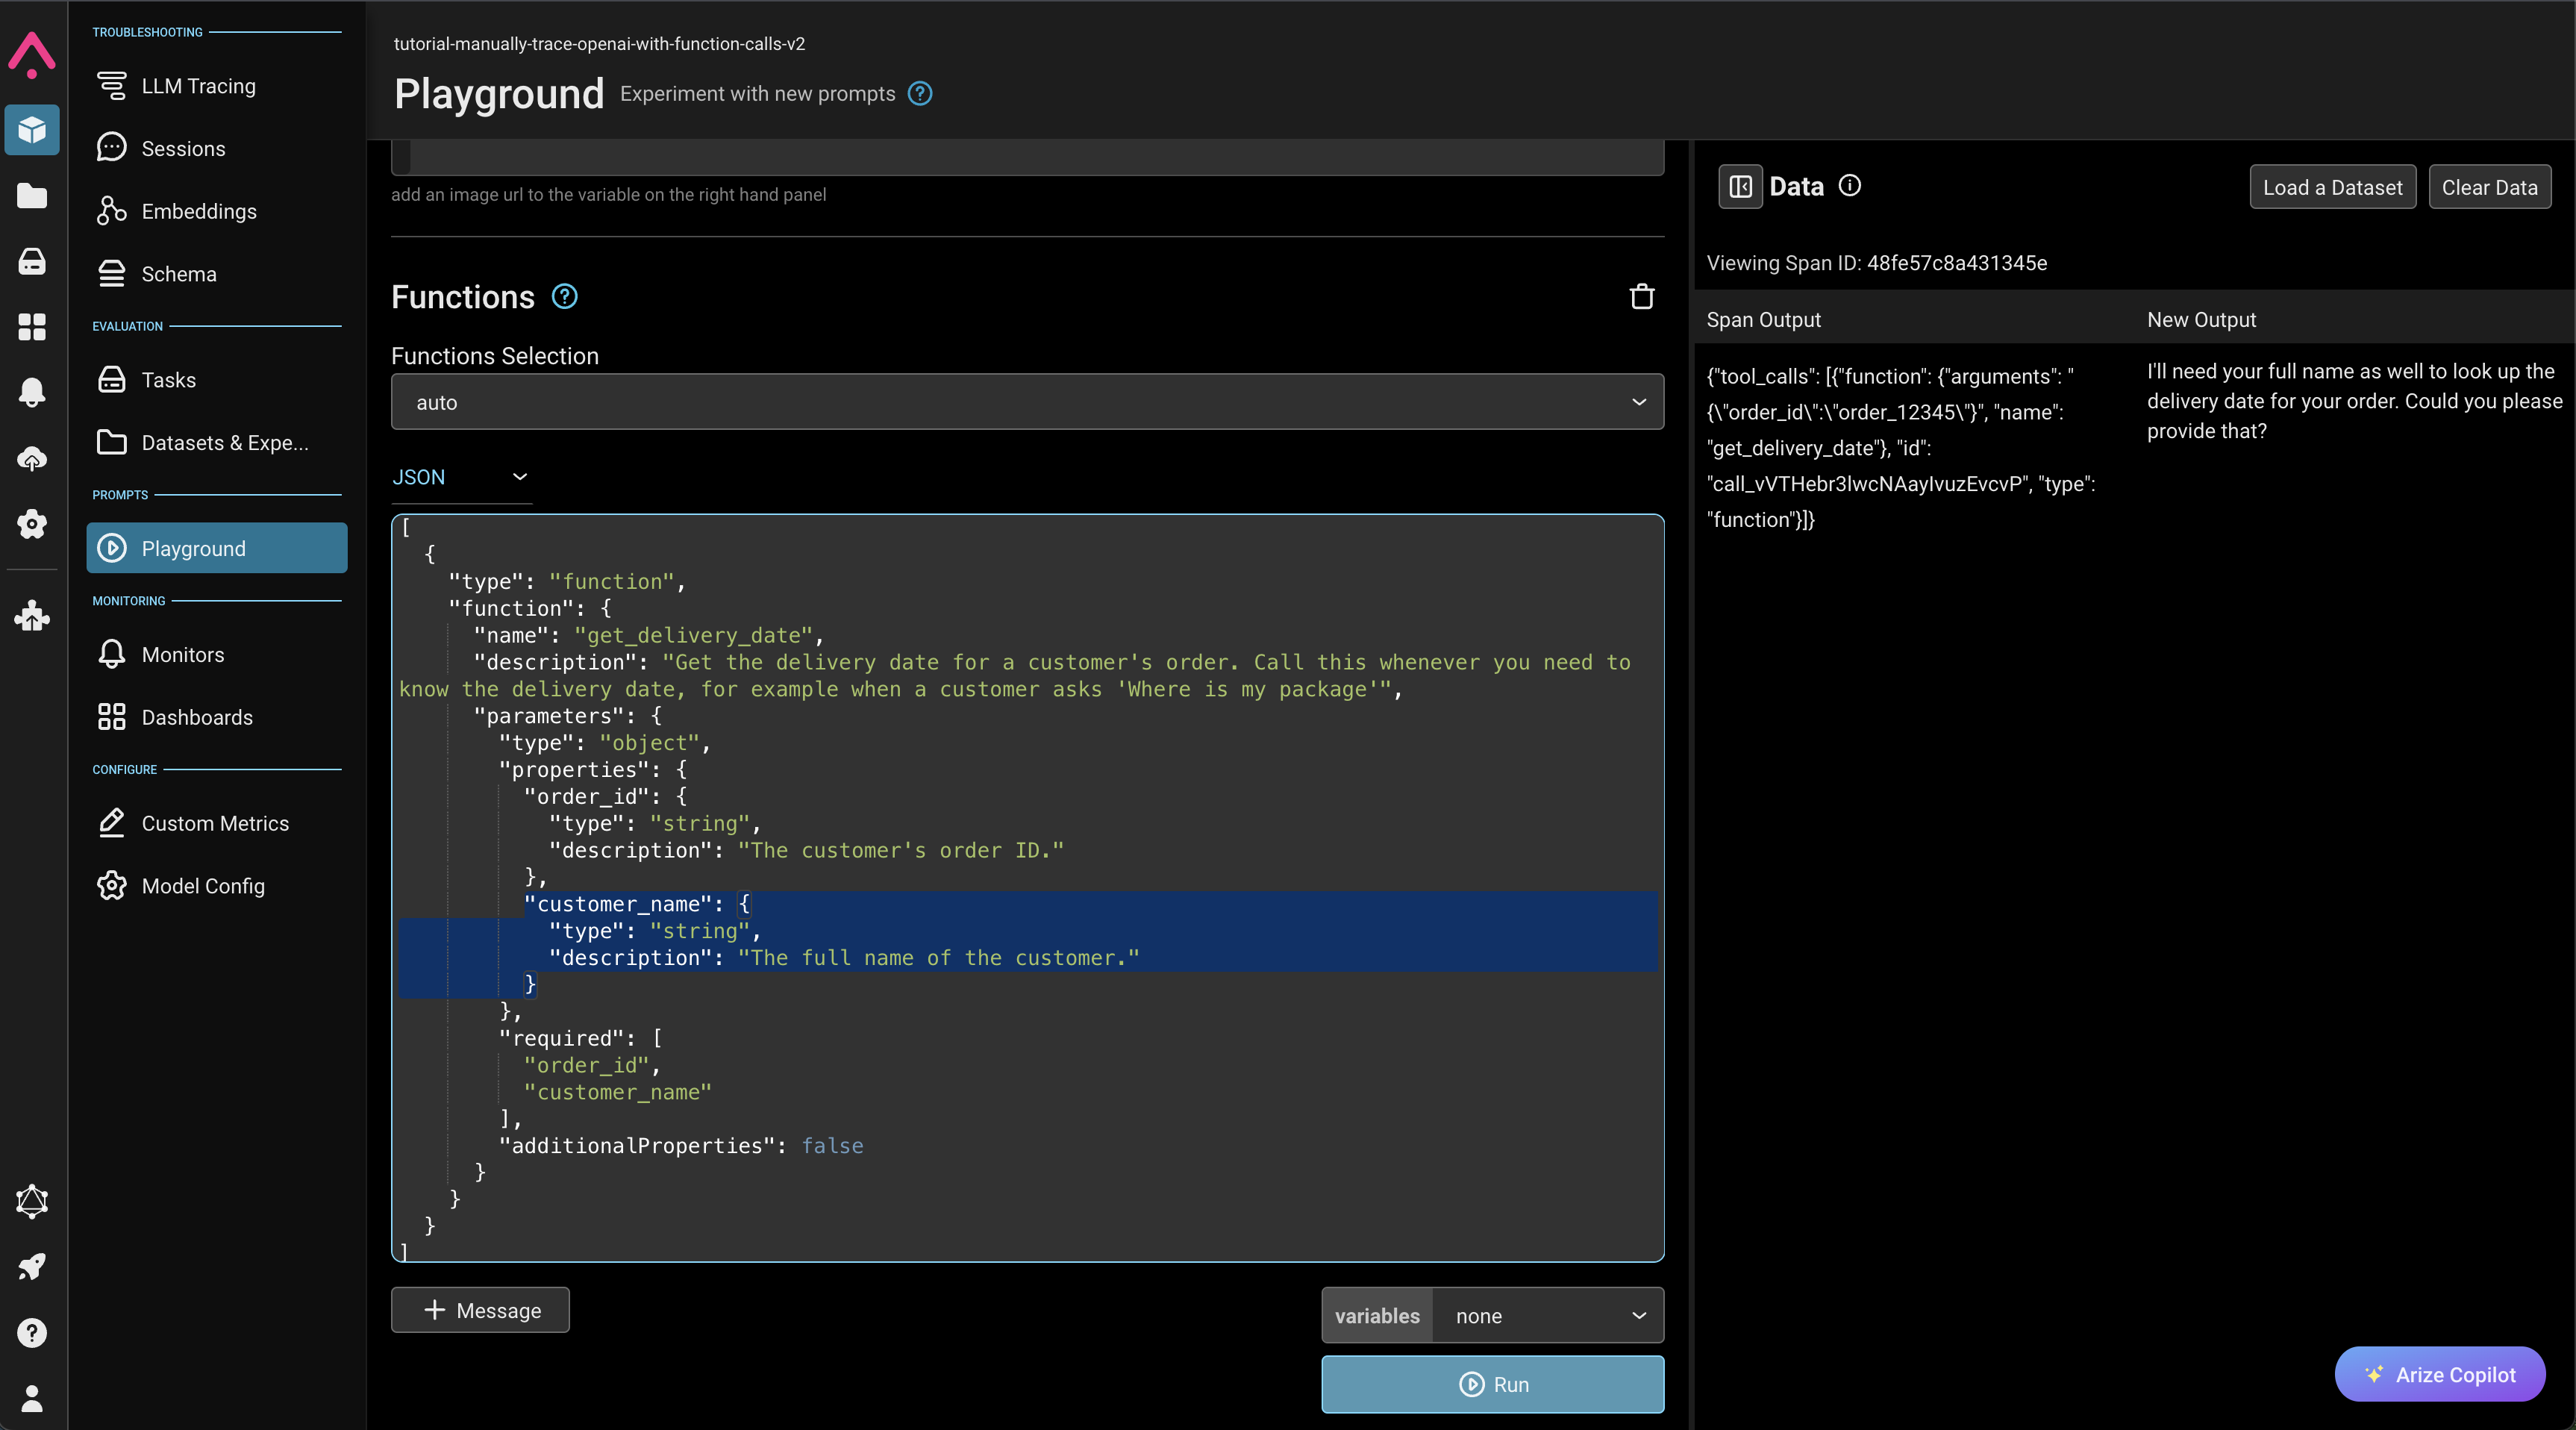

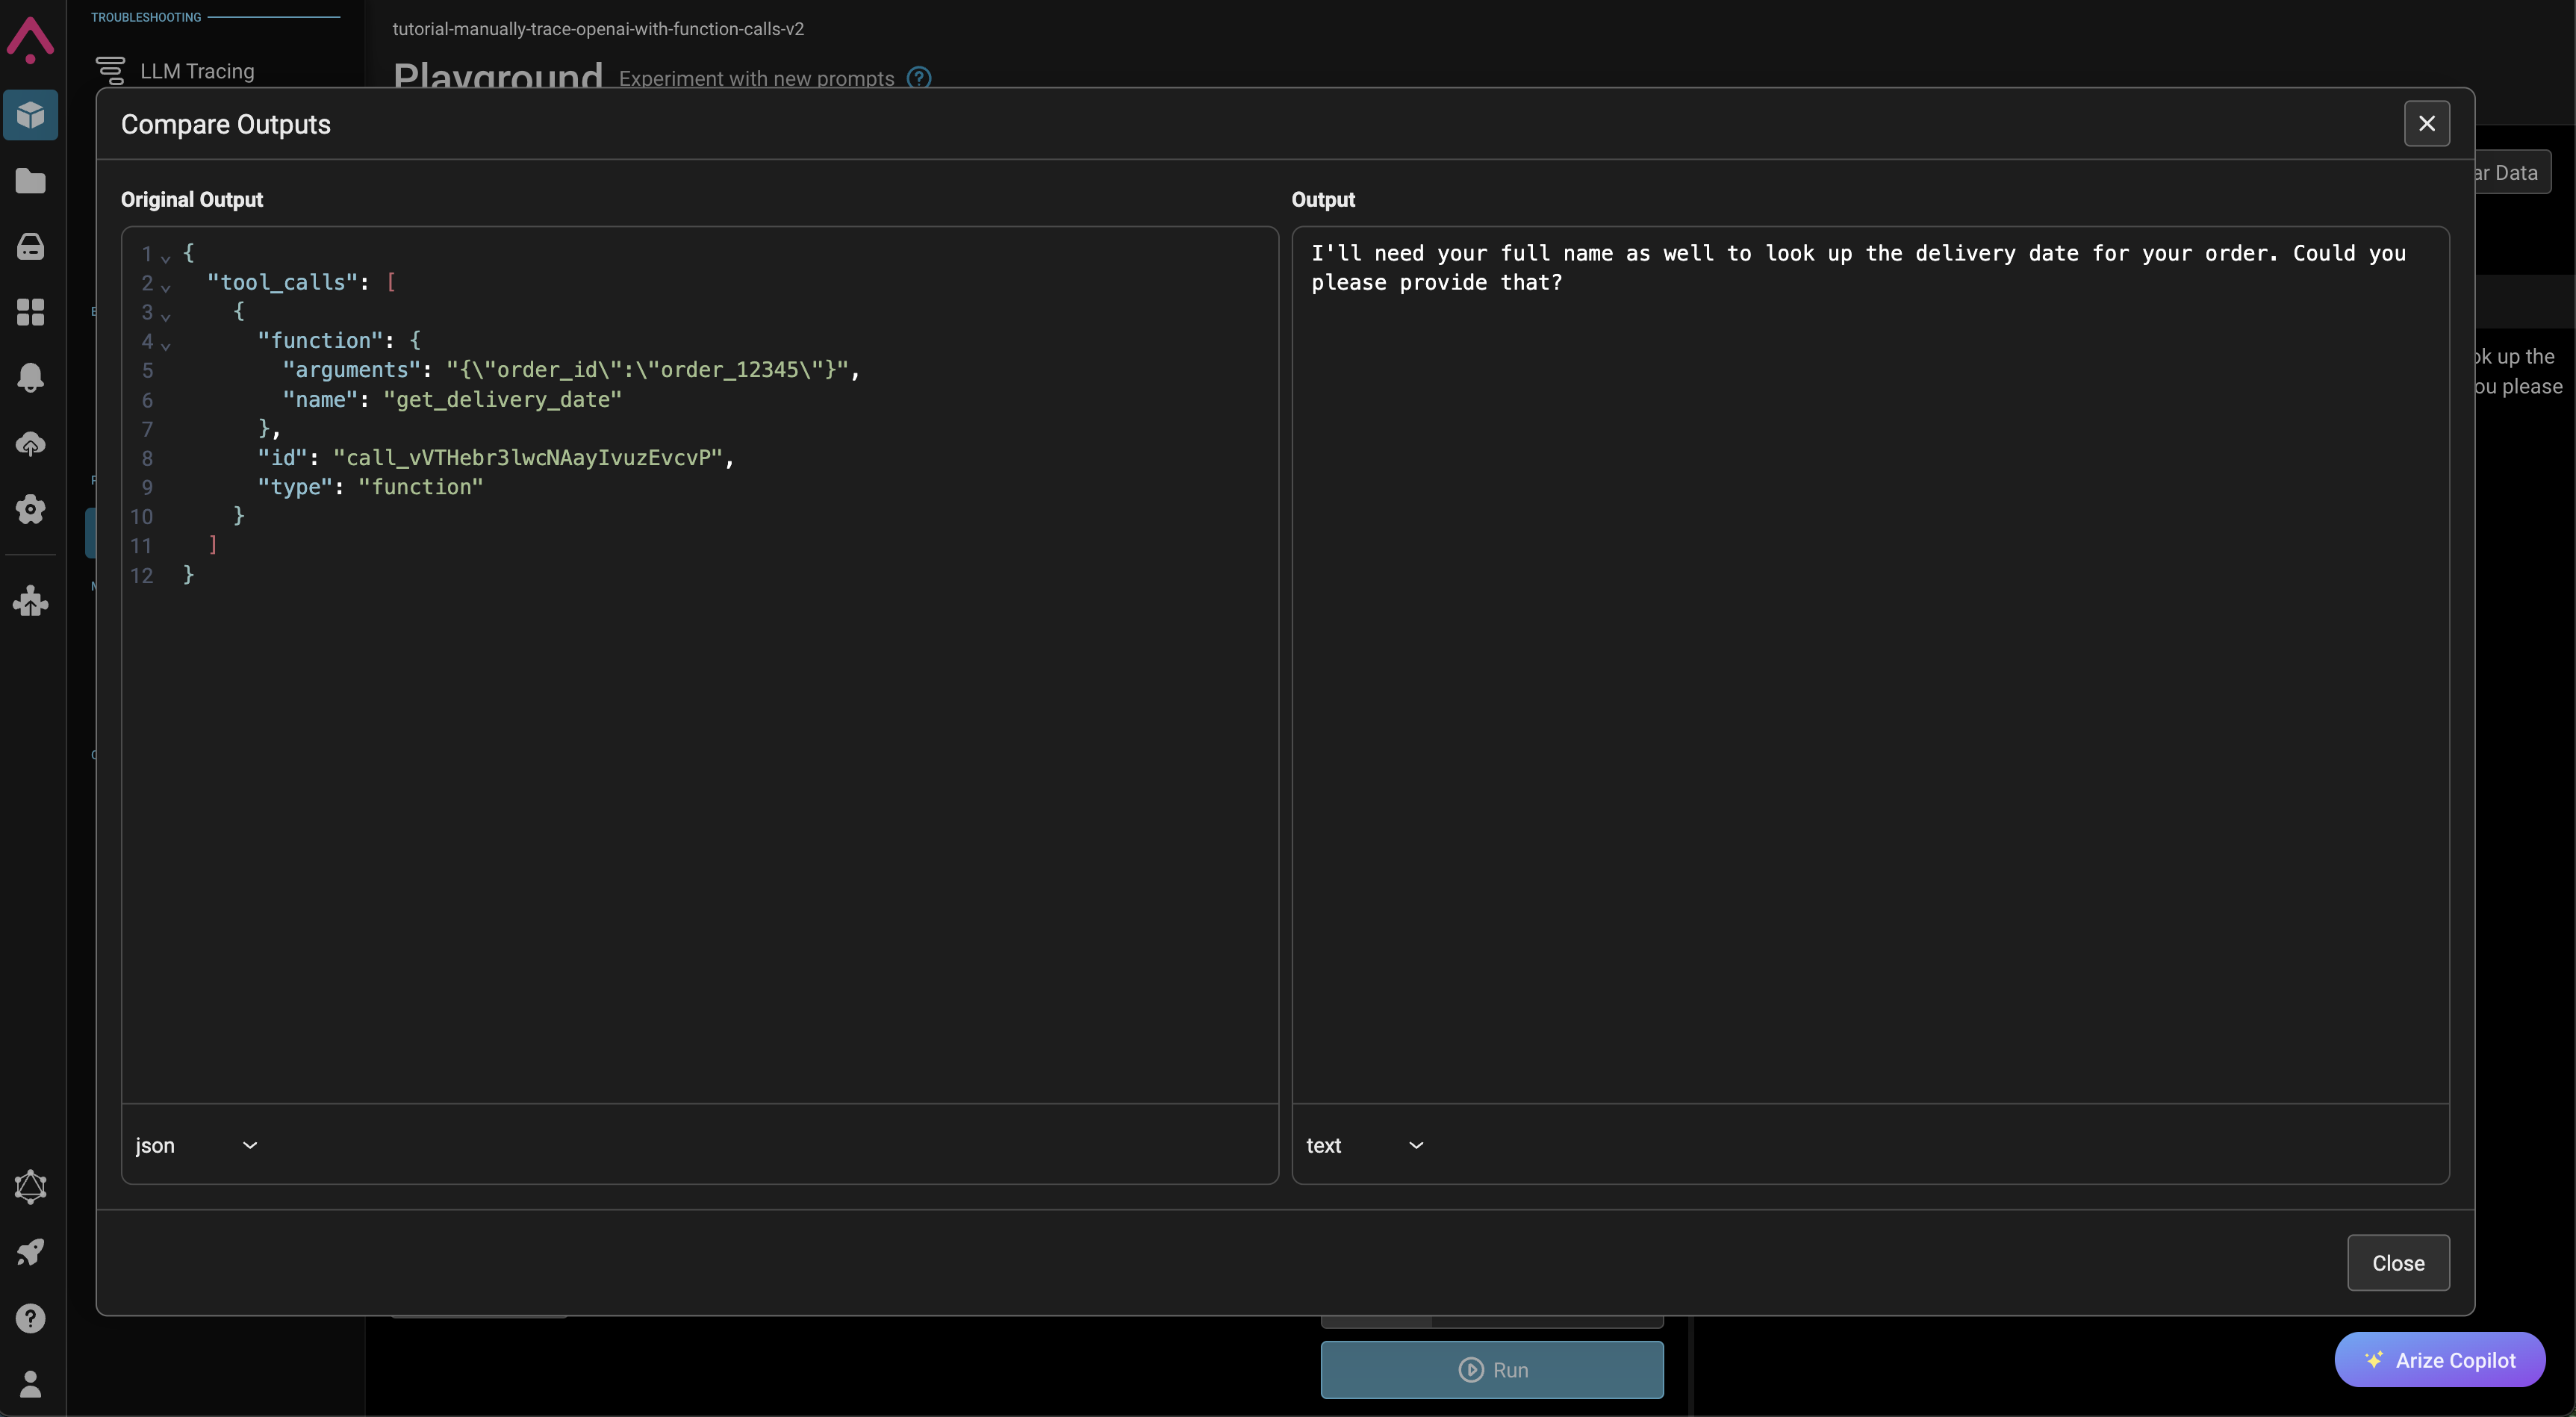